## Surprise Housing Assignment

Goal of this assignment is to build an optimal model which can predict the price of the property. Also, the model should be able to tell which factors are main drivers in the price of the house. 

For this assignment we will follow below steps:
1. Reading and Understanding Data
2. Data Visualisation
3. Data Preparation
4. Feature selection using RFE
5. Data modeling using Ridge and Lasso
6. Features that are important in predicting the SalePrice


After this, we will update model to answer subjective questions in Part II of the assignment


In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Reading and Understanding Data

In [2]:
# load CSV

#df = pd.read_csv('train.csv', keep_default_na=False)
df = pd.read_csv('train.csv')

In [3]:
# Check if the data is loaded correctly

df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

 - We see quite a NaN values for string columns
 - NaN may need to be converted to 'NA' 
 - For numeric columns NA are correctly read as 0s 


In [4]:
# Check the shape of the dataframe
df.shape

(1460, 81)

In [5]:
# check the data types and nulls for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

 - Columns like 'Alley', FireplaceQu, Pool QC, Fence, MiscFeature are NA for more than 60% of the values
 - We can either impute them or drop them as we may not have good representation of such values for the model

In [6]:
## Check the null %
cols = round(df.isnull().mean()*100,2)

## any columns that are 100% null, store them in an list
null_cols = []
i = len(cols)
for i in range(0,len(cols)):
    if cols[i] >60:
        null_cols.append(cols.index[i])

In [7]:
## which which columns have nulls for more than 60%
print(null_cols)

['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [8]:
## drop the columns from the null_colls list
for null_col in null_cols:
    df = df.drop(null_col, axis=1)

In [9]:
## We also have Id column which can be dropped as it won't be used in predicting the value of the property.
df = df.drop(['Id'],axis=1)

##### Imputing NA or NaN values for various columns below

In [10]:
cols = round(df.isnull().mean()*100,2)

partial_nulls = []
for i in range(0,len(cols)):
    if cols[i] > 0:
        partial_nulls.append(cols.index[i])

In [11]:
partial_nulls

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [12]:
for partial_null_col in partial_nulls:
    print('\nUnique values for ', partial_null_col ,':\n', df[partial_null_col].unique())



Unique values for  LotFrontage :
 [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]

Unique values for  MasVnrType :
 ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]

Unique values for  MasVnrArea :
 [1.960e+02 0.000e+00 1.620e+02 3.500e+02 1.860e+02 2.400e+02 2.860e+02
 3.060e+02 2.120e+02 1.800e+02 3.800e+02 2.810e+02 6.400e+02 2.000e+02
 2.460e+02 1.320e+02 6.500e+02 1.010e+02 4.120e+02 2.720e+02 4.560e+02
 1.031e+03 1.780e+02 5.730e+02 3.440e+02 2.870e+02 1.670e+02 1.115e+03
 4.000e+0

In [13]:
# Let's segregate the columns as partial and categorical as we need to treat NaN values

partial_num_cols = ['LotFrontage','MasVnrArea','GarageYrBlt']
partial_cat_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','GarageCond','FireplaceQu']


In [14]:
# Let's initialise values to 0 for NaN

for partial_nul_col in partial_num_cols:
    df[partial_nul_col] = df[partial_nul_col].apply(lambda x: 0 if math.isnan(x) else x)

In [15]:
# Let's initialise to NA for the categorical varaibles where there is NaN

for partial_cat_col in partial_cat_cols:
    df[partial_cat_col] = df[partial_cat_col].apply(lambda x:str(x))
    df[partial_cat_col] = df[partial_cat_col].apply(lambda x: 'NA' if x=='nan' else x)

In [16]:
# We treat 'MasVnrType' differently as it has 'None' as blanks

df['MasVnrType'] = df['MasVnrType'].apply(lambda x:str(x))
df['MasVnrType'] = df['MasVnrType'].apply(lambda x: 'None' if x=='nan' else x)

In [17]:
# We treat 'Electrical' differently as it does not have 'NA' as a value

df['Electrical'] = df['Electrical'].apply(lambda x:str(x))
df['Electrical'] = df['Electrical'].apply(lambda x: 'SBrkr' if x=='nan' else x)

In [18]:
# check the dataframe now
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

- We see that we have address all null or NaN values
- All the numerical variables are either int or floats
- All string variables are stored as object

## Data Visualisation

In [19]:
## Let's divide the vars in Numerical Cols and Categorical cols

numerical_cols = []
categorical_cols = []

for col in df.columns:
    if df[col].dtype in ('int64','float64'):
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)

print('Numerical columns:\n',numerical_cols)
print('\nCategorical columns:\n',categorical_cols)

Numerical columns:
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

Categorical columns:
 ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'Garage

### Let's visualise SalePrice against the numerical cols

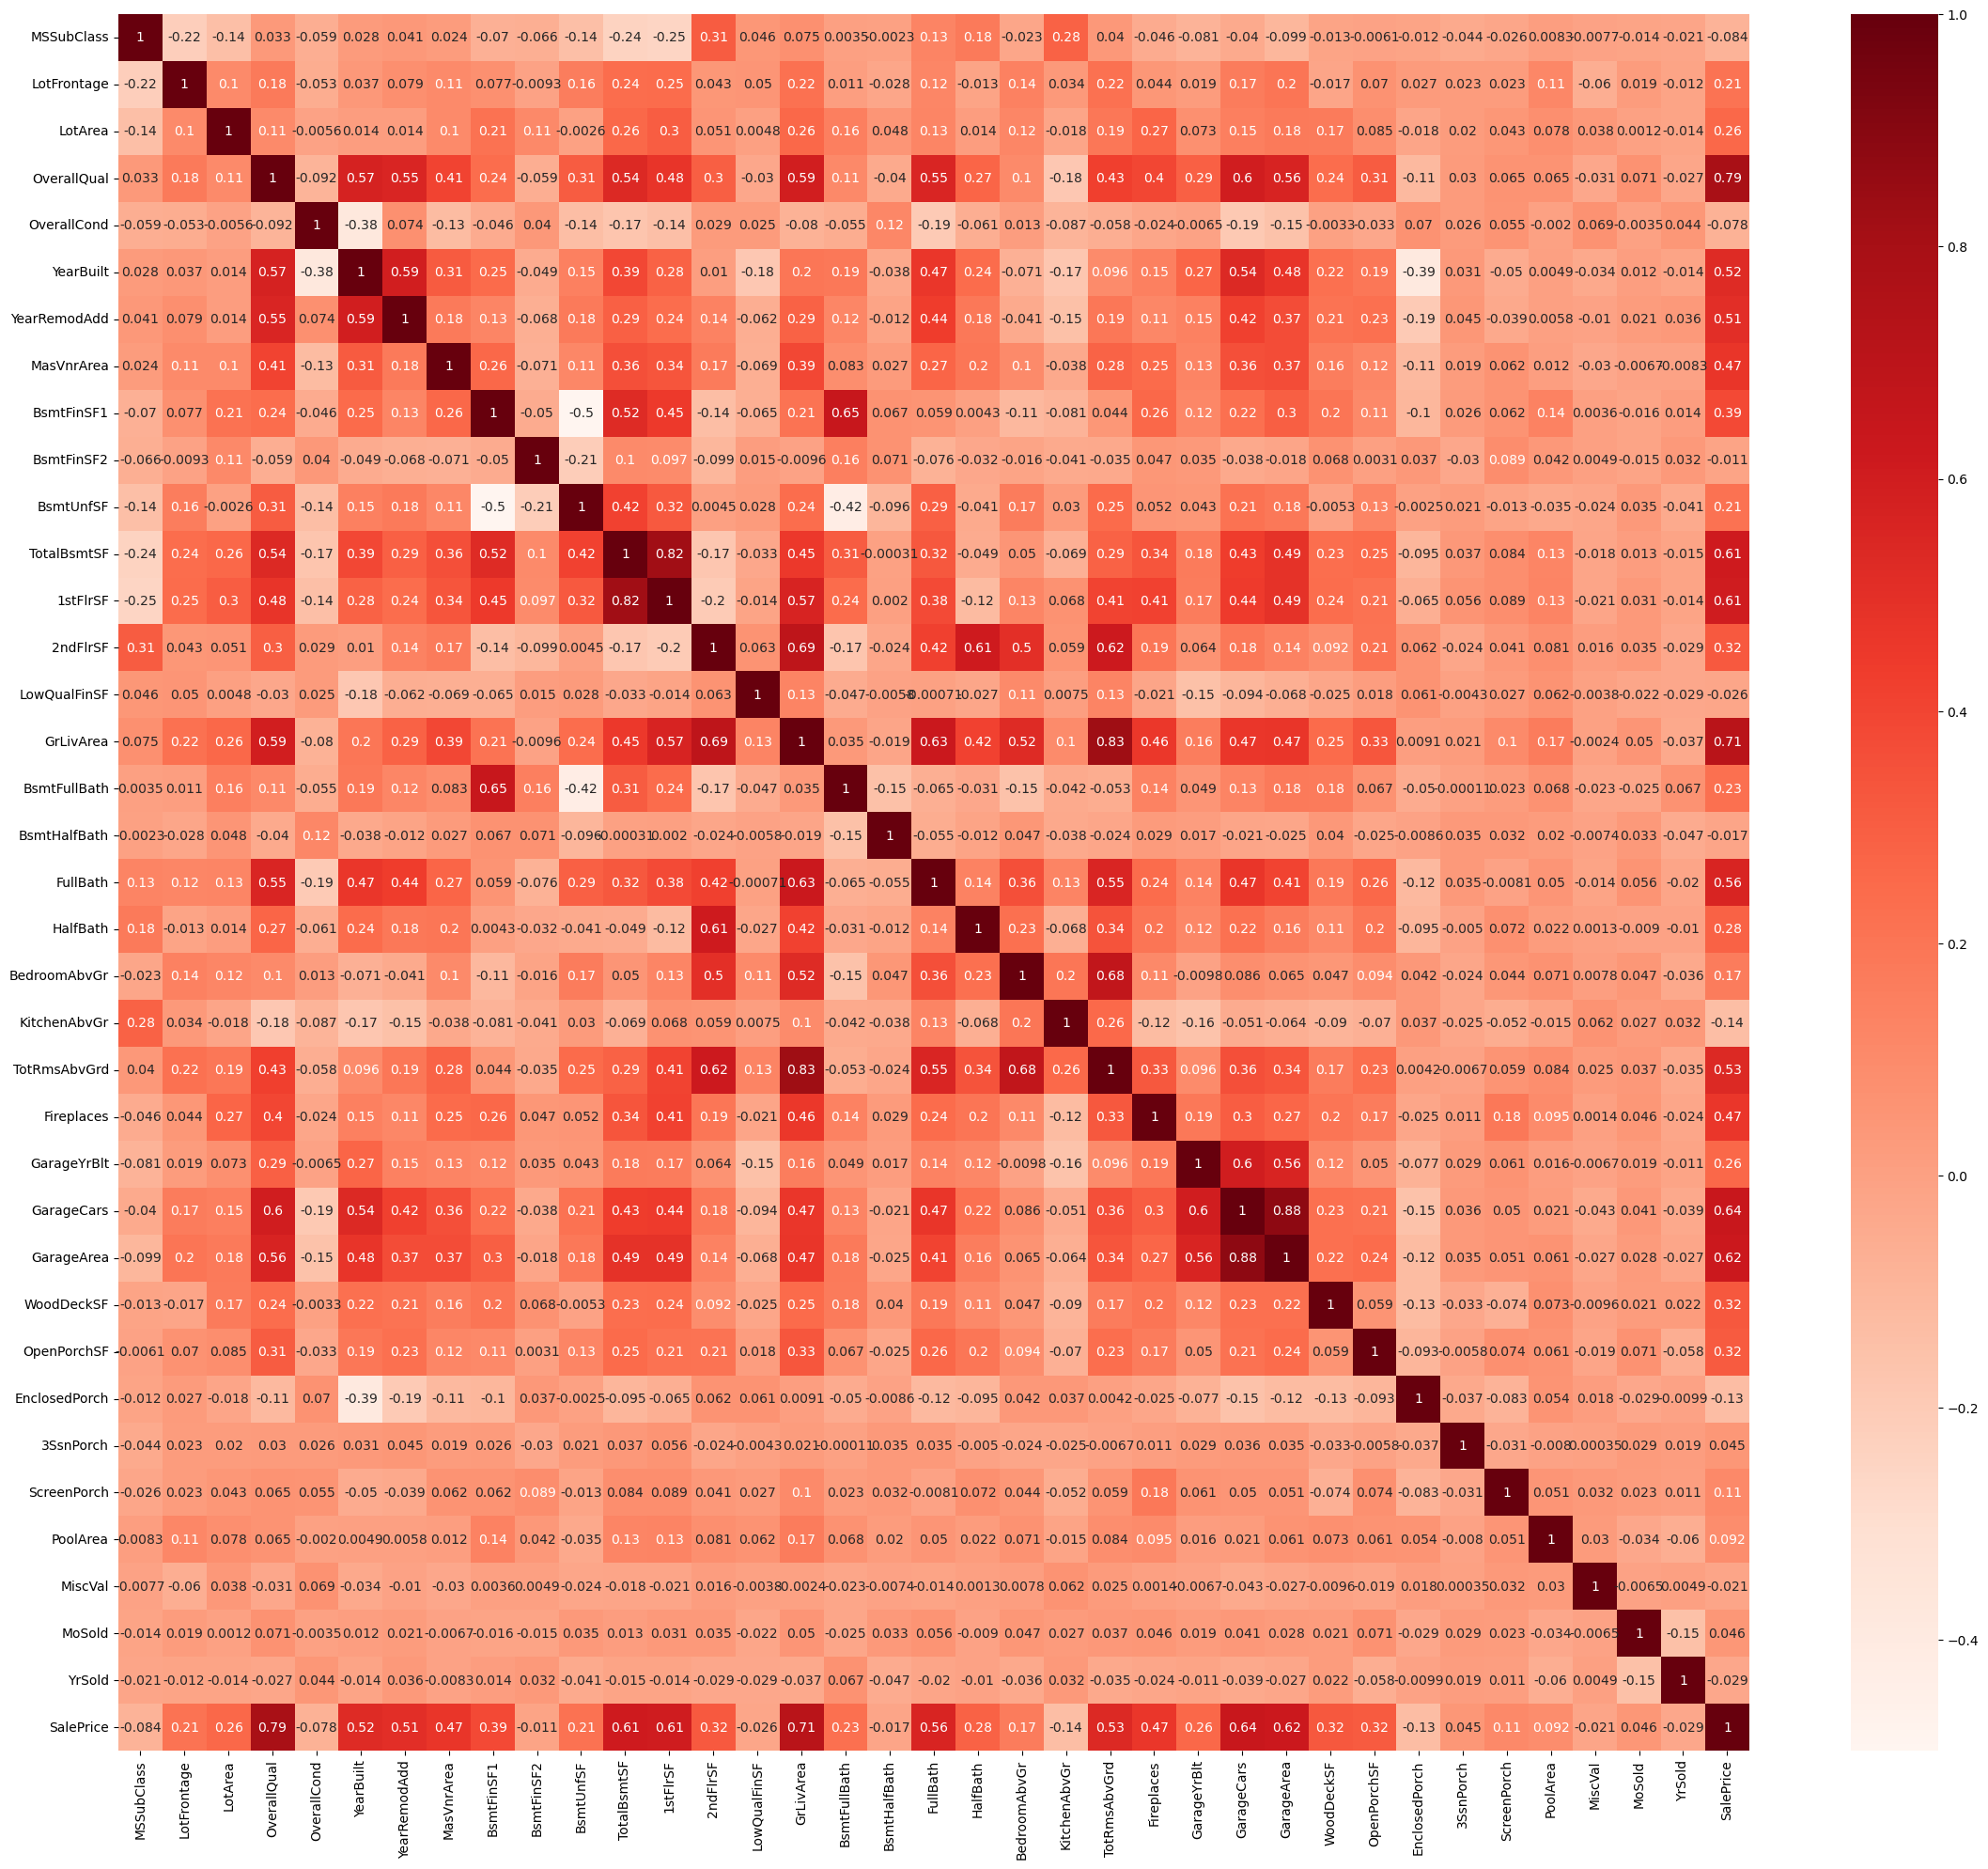

In [20]:
## Let's plot heatmap for all numerical vals
plt.figure(figsize=(28,24))
sns.heatmap(df[numerical_cols].corr(),cmap='Reds',annot=True)
plt.show()

- We see SalePrice is strongly correlated to -
    - OverallQual
    - YearBuilt
    - YearRemodAdd
    - TotalBsmtSF
    - 1stFlrSF
    - GrLivArea
    - TotRmsAbvGrd
    - GarageCars
 - SalePrice is also correlated to -
    - LotFrontage
    - LotArea
    - MasVnrArea
    - BsmtFinSF1
    - 2ndFlrSF
    - BsmtFullBath
    - HalfBath
    - GarageArea
    - WoodDeckSF
    - OpenPorchSF
    

#### Let's plot clustermap since we see some properties interlinked to each other

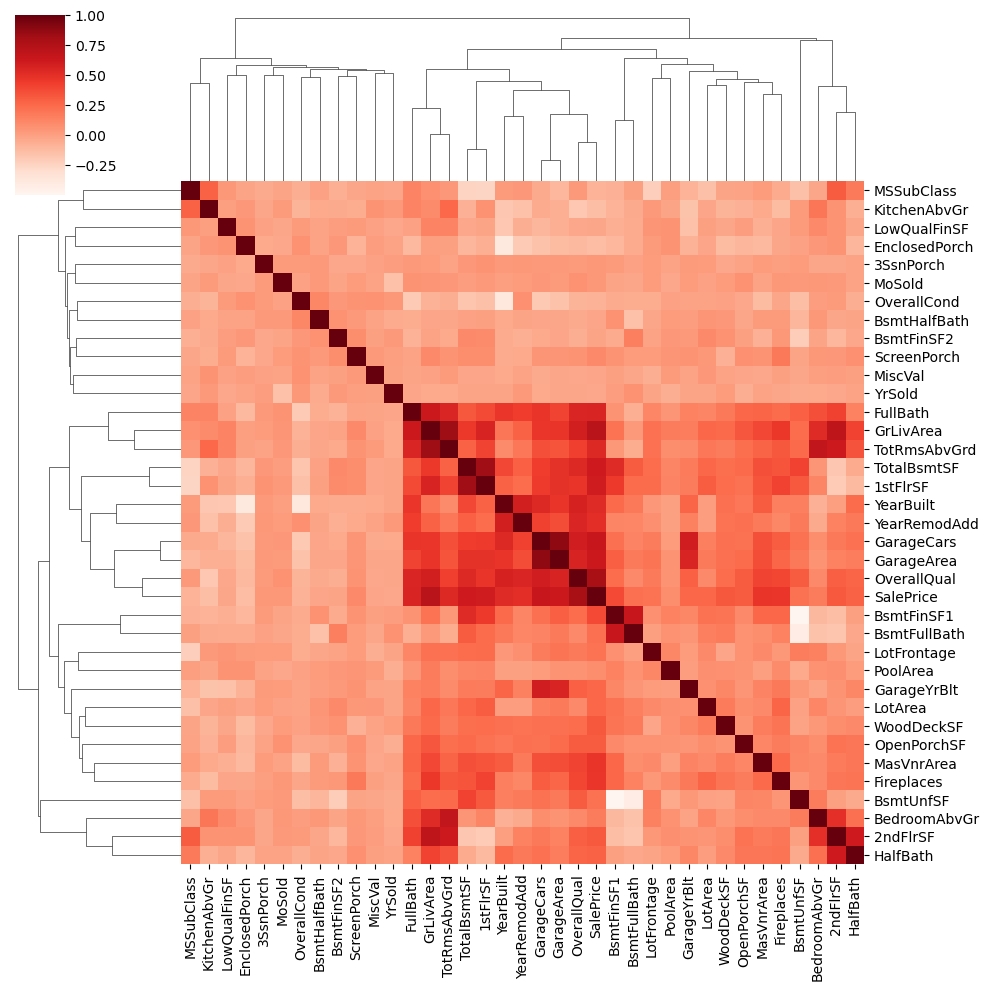

In [21]:
sns.clustermap(df[numerical_cols].corr(), cmap='Reds')
plt.show()

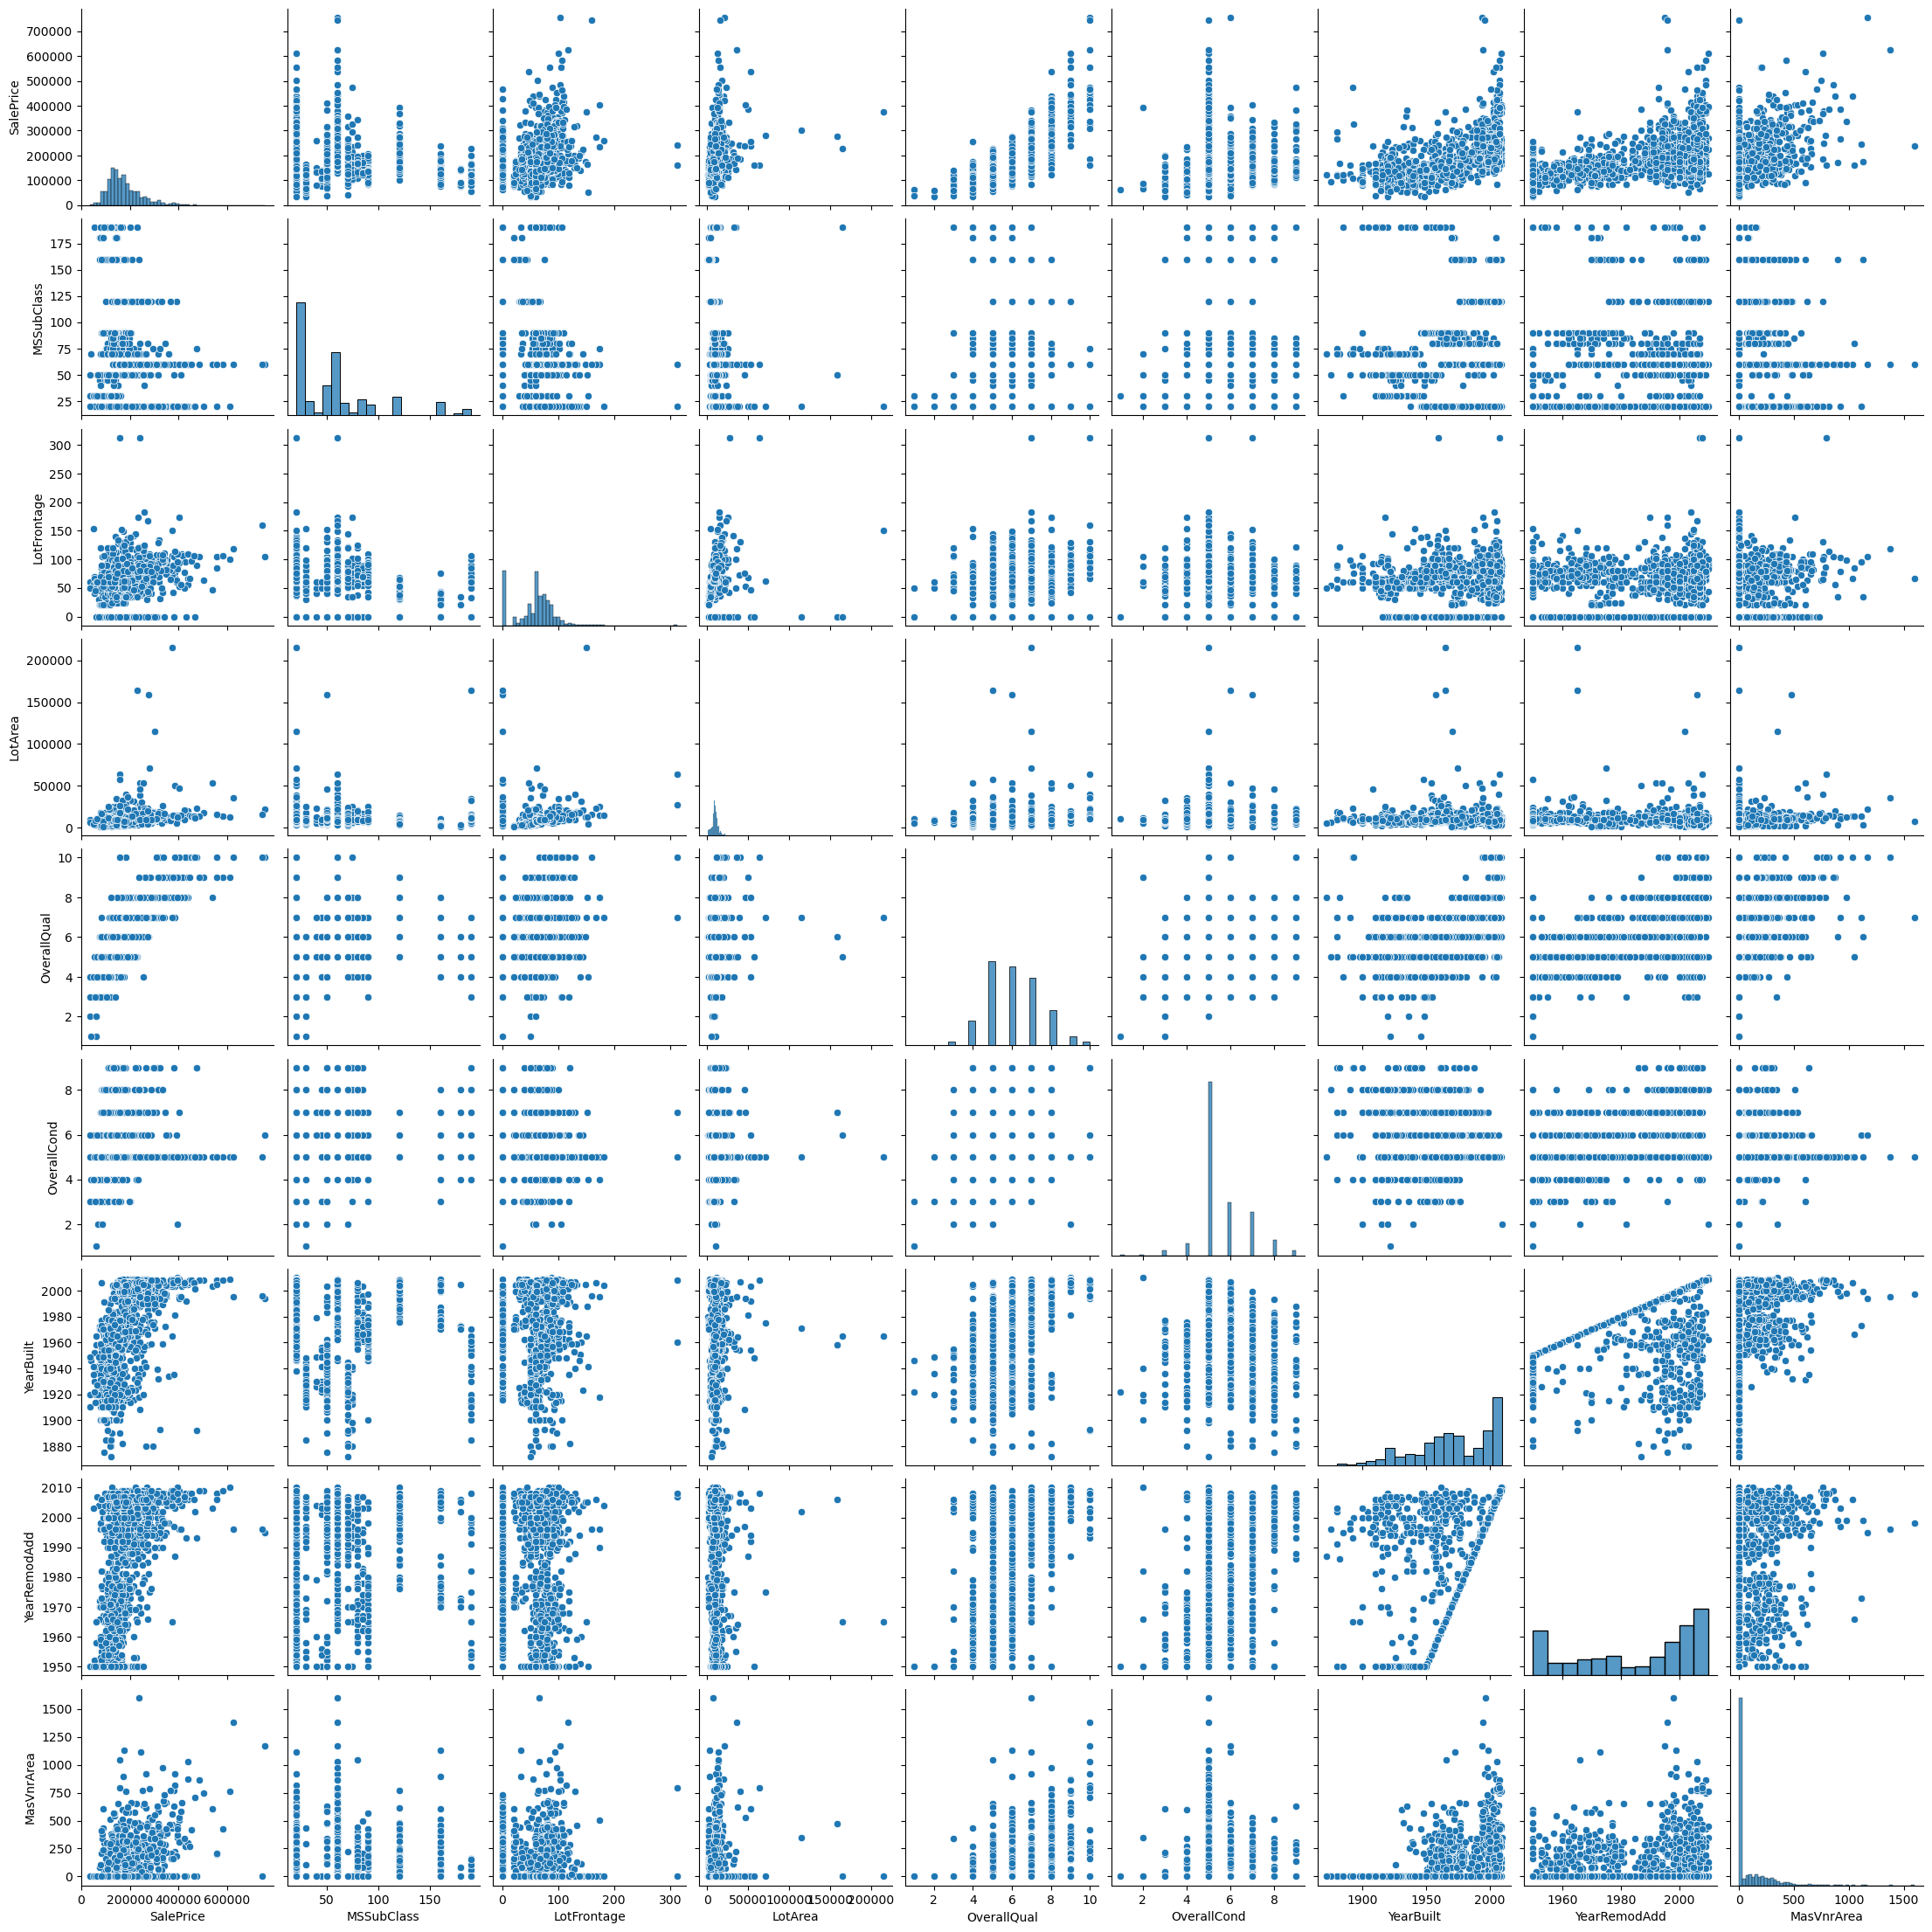

In [22]:
sns.pairplot(df[['SalePrice','MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt','YearRemodAdd','MasVnrArea']])

plt.show()


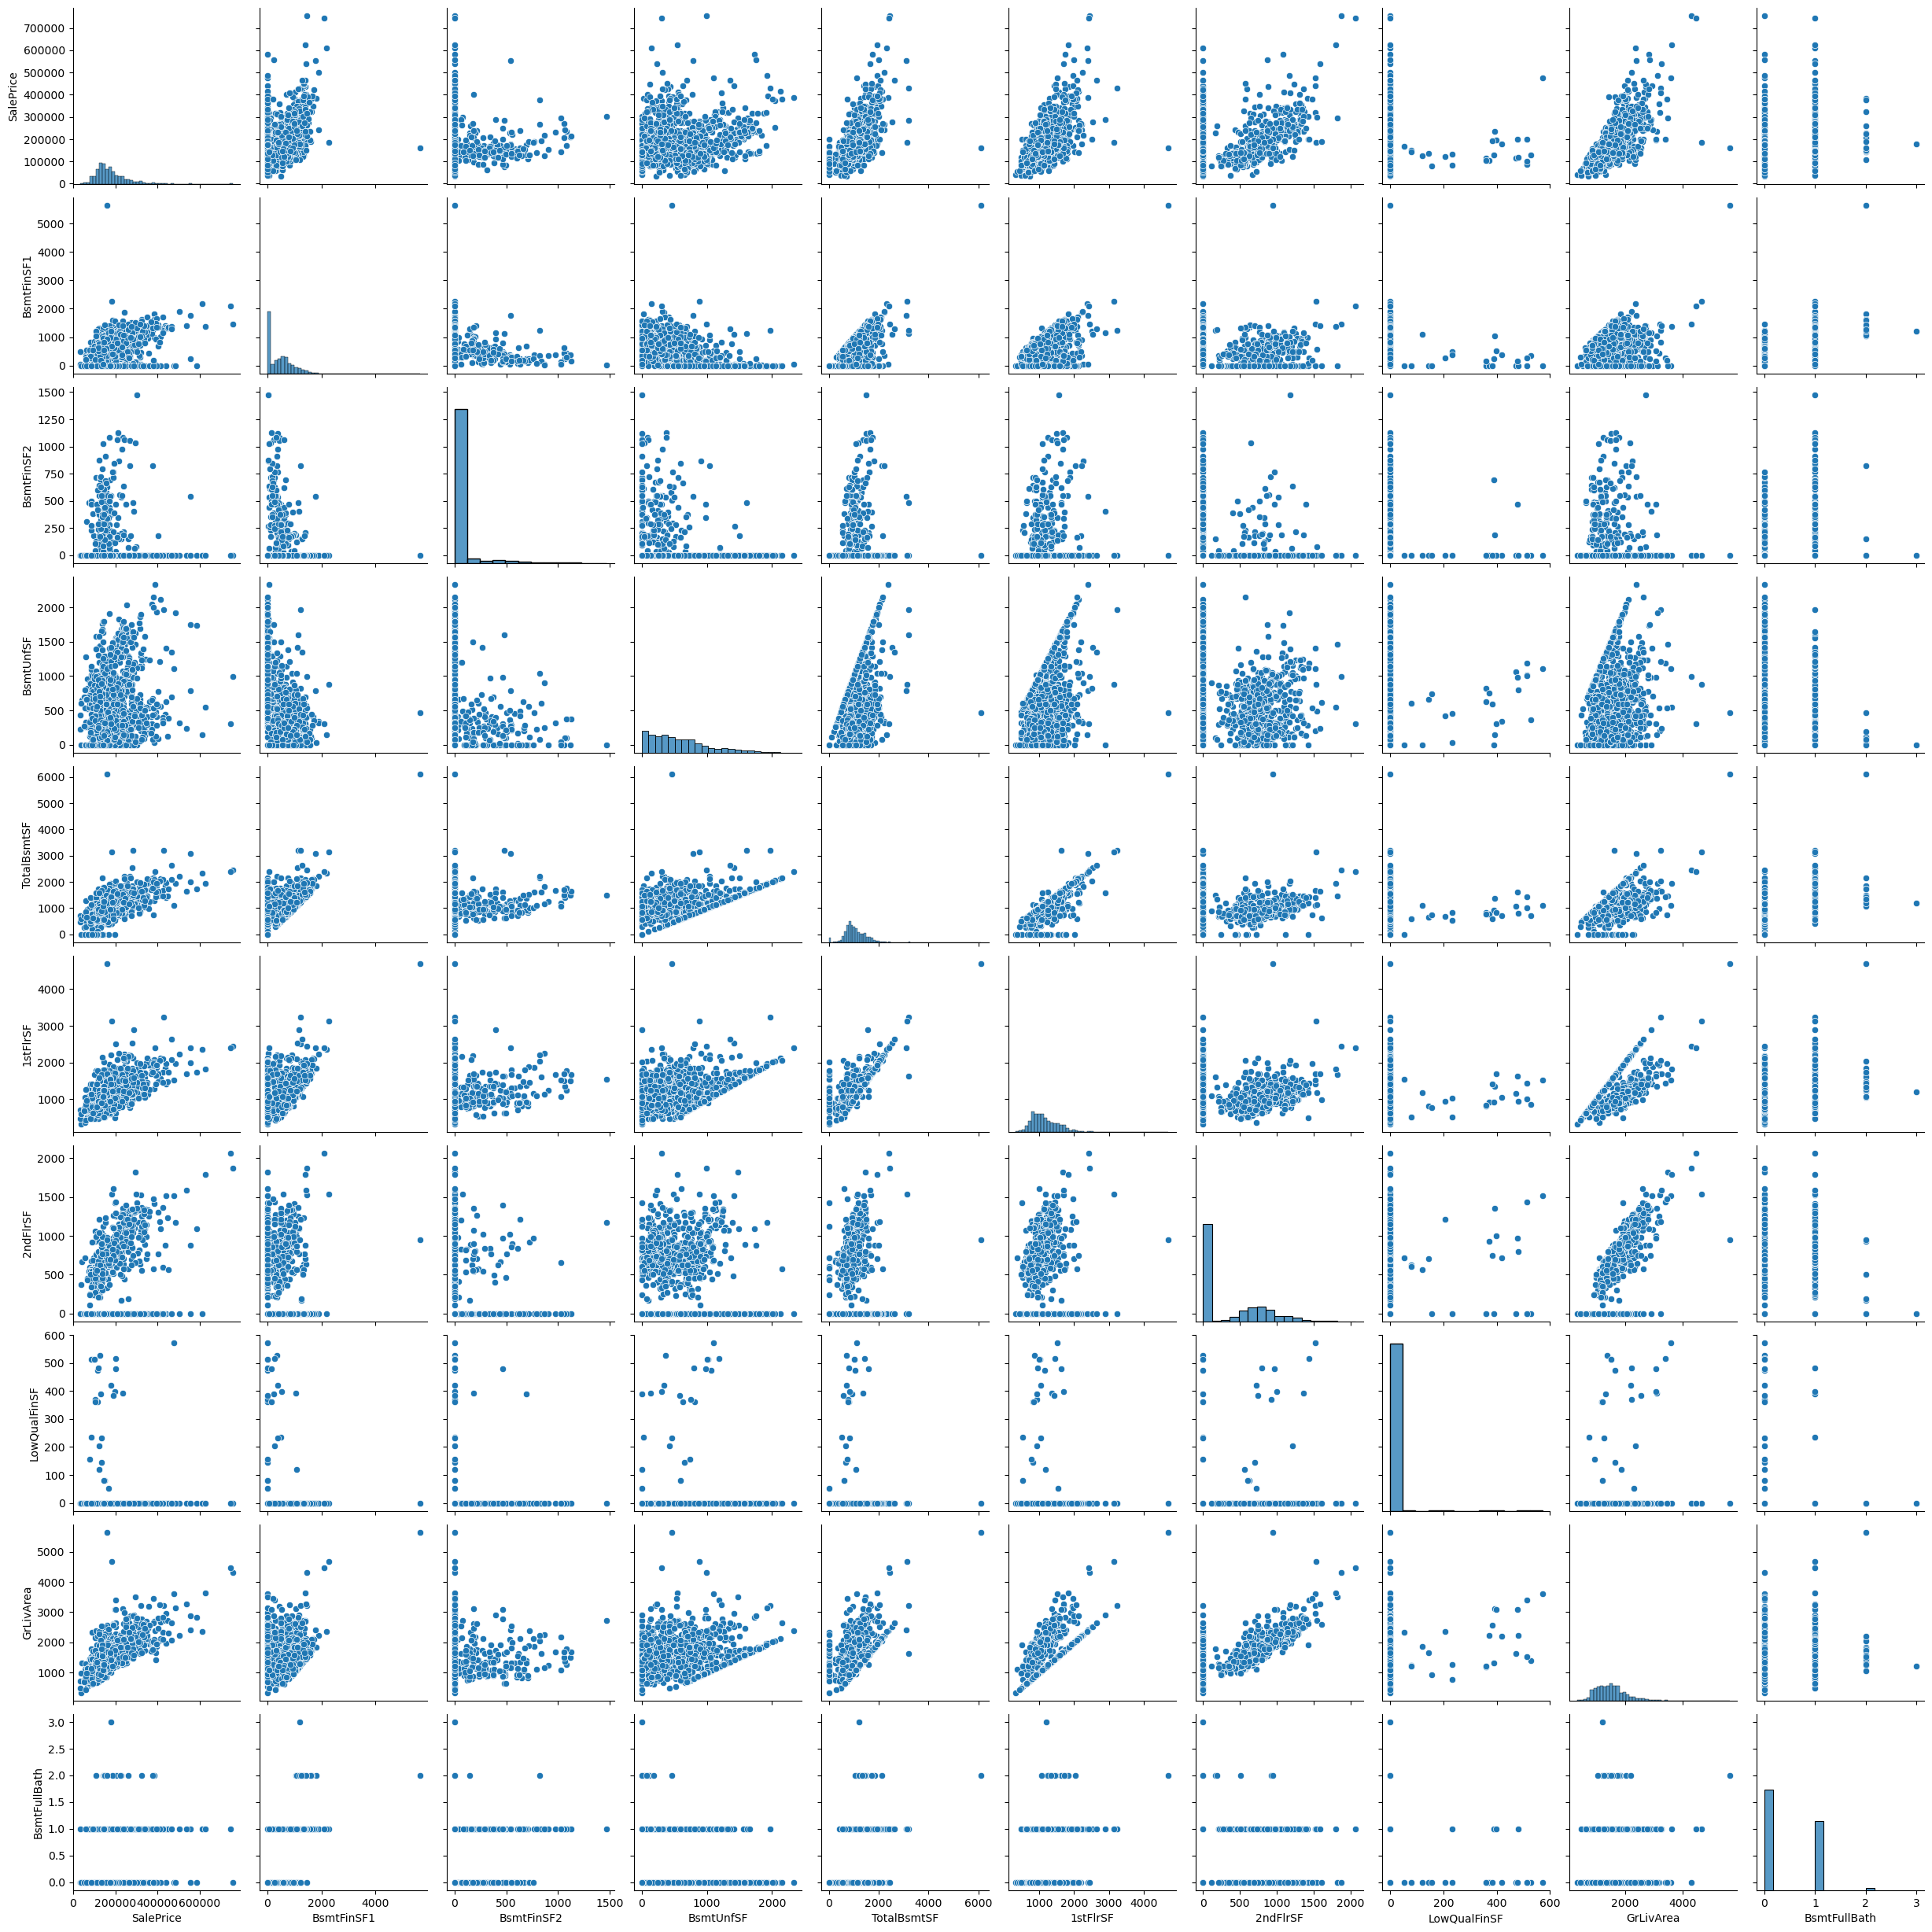

In [23]:
sns.pairplot(df[['SalePrice','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath']])
plt.show()


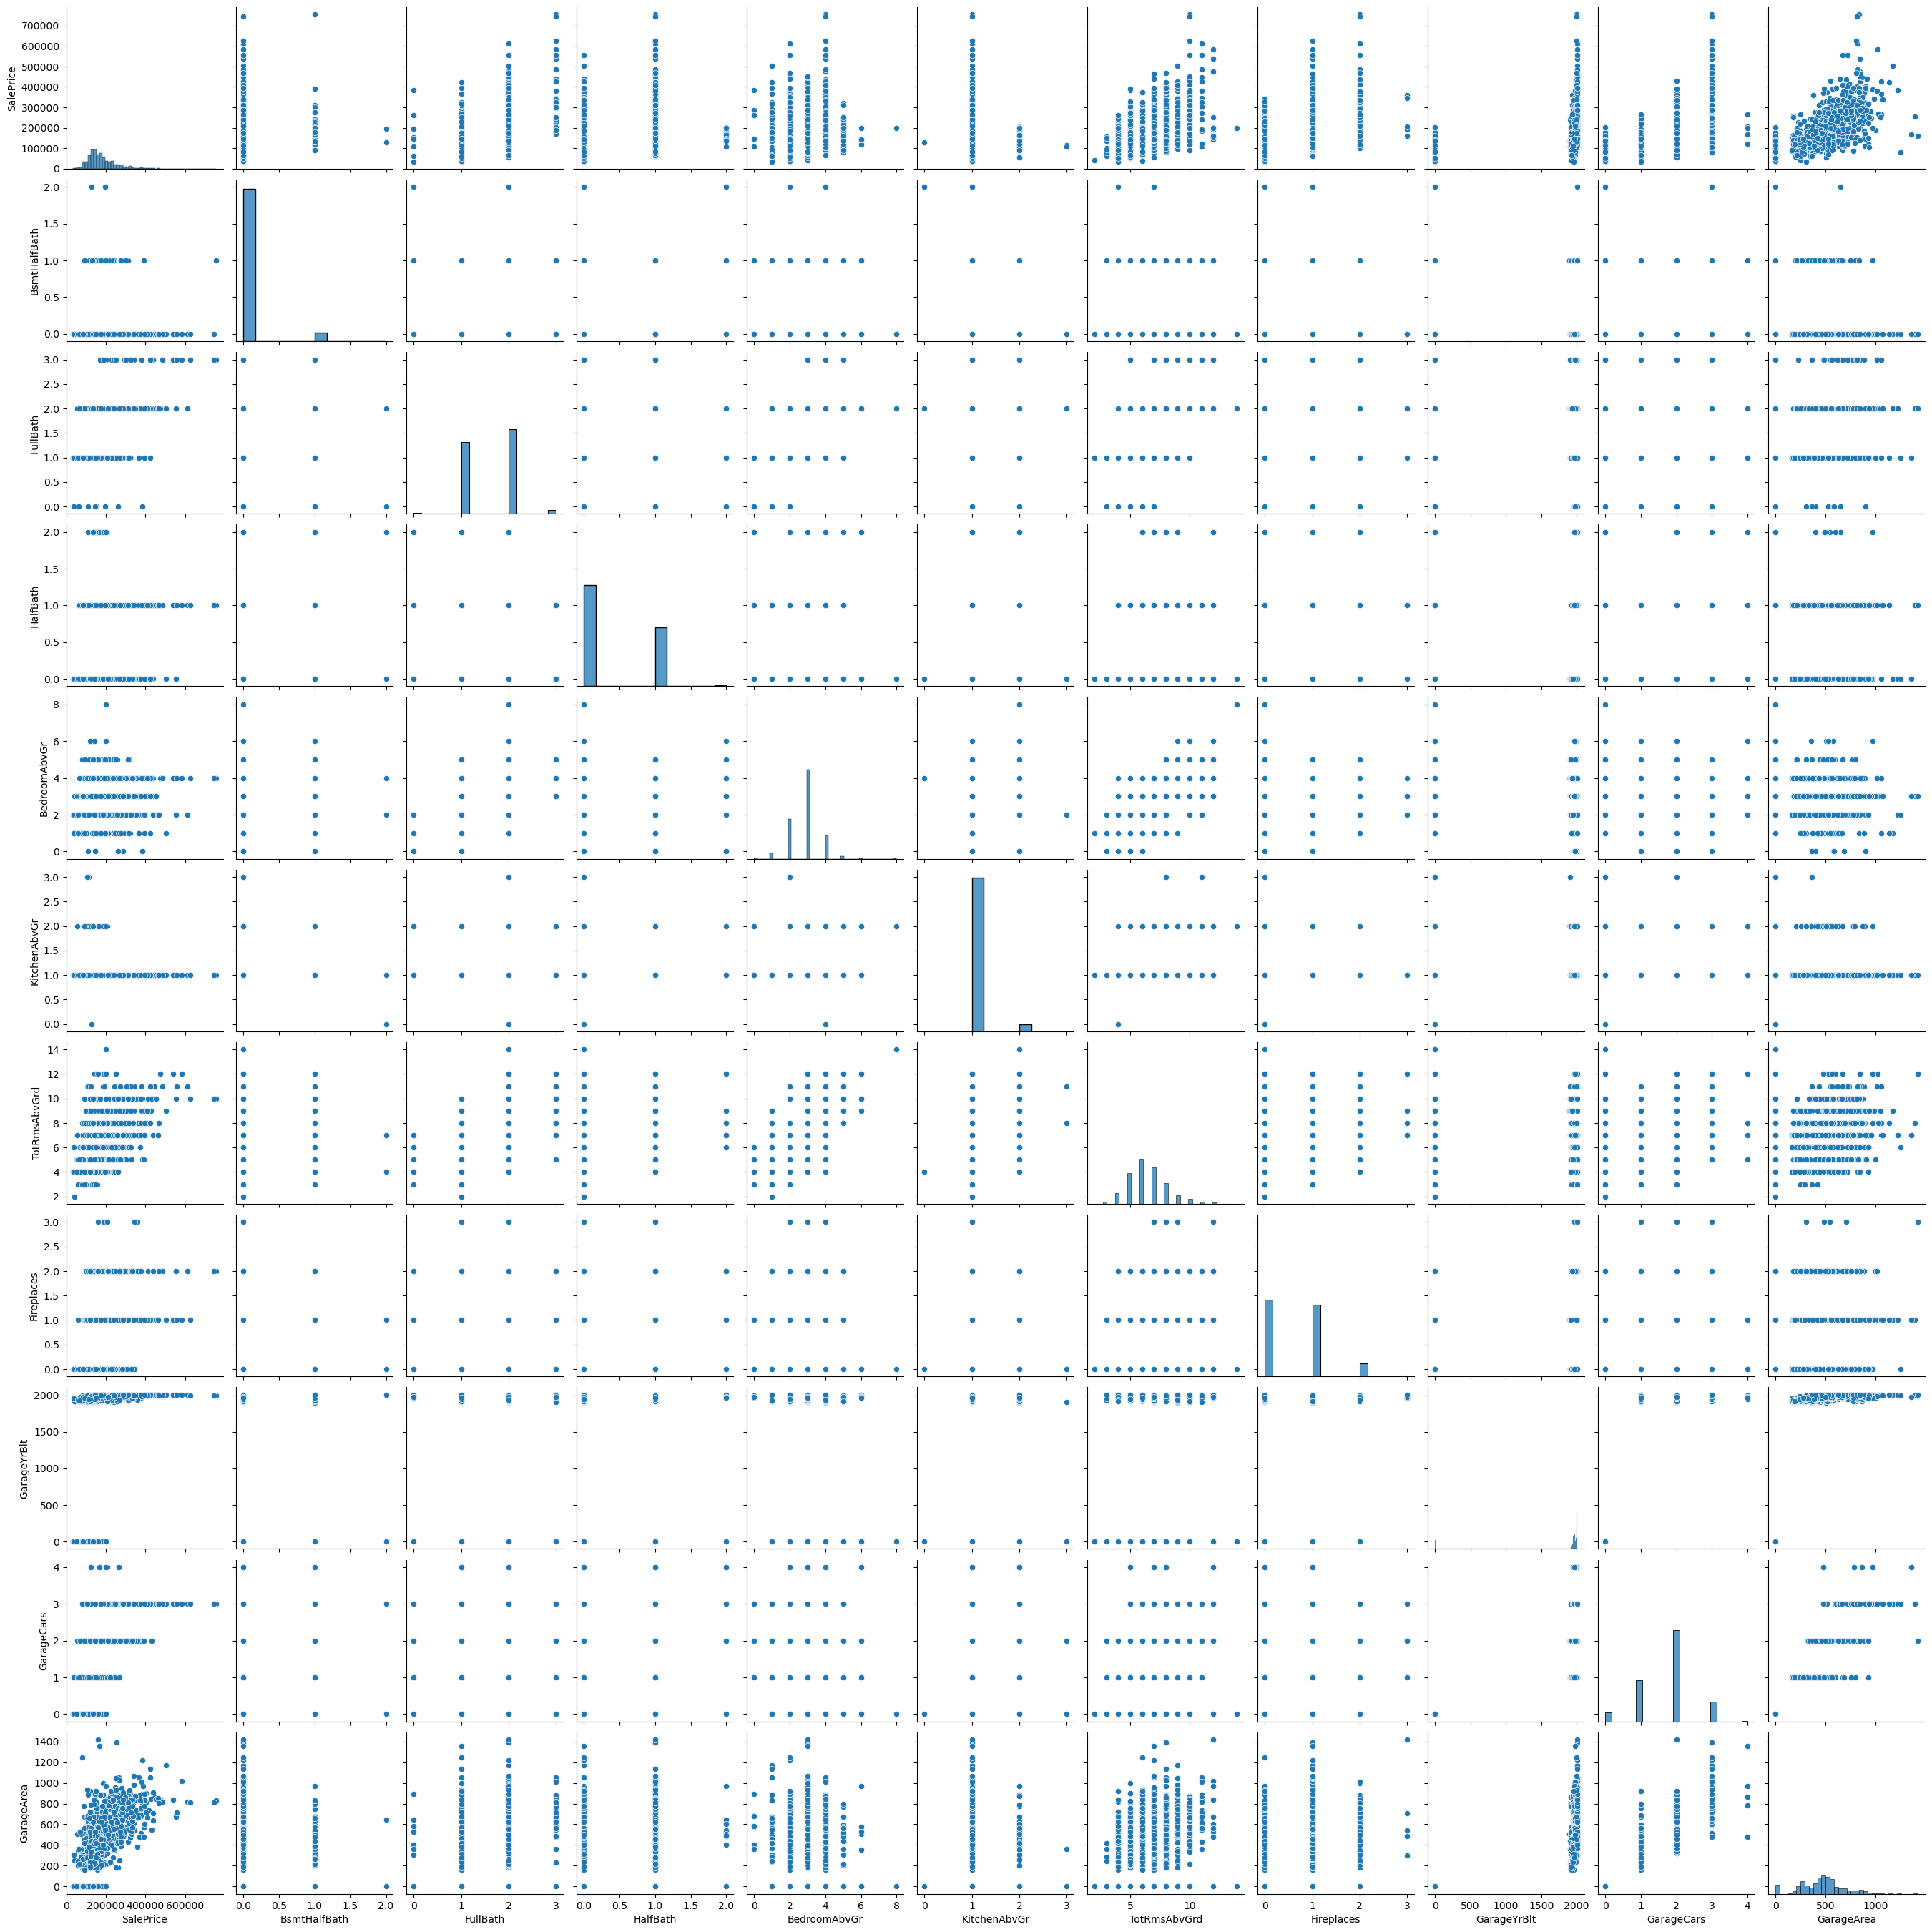

In [24]:
sns.pairplot(df[['SalePrice','BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea']])
plt.show()


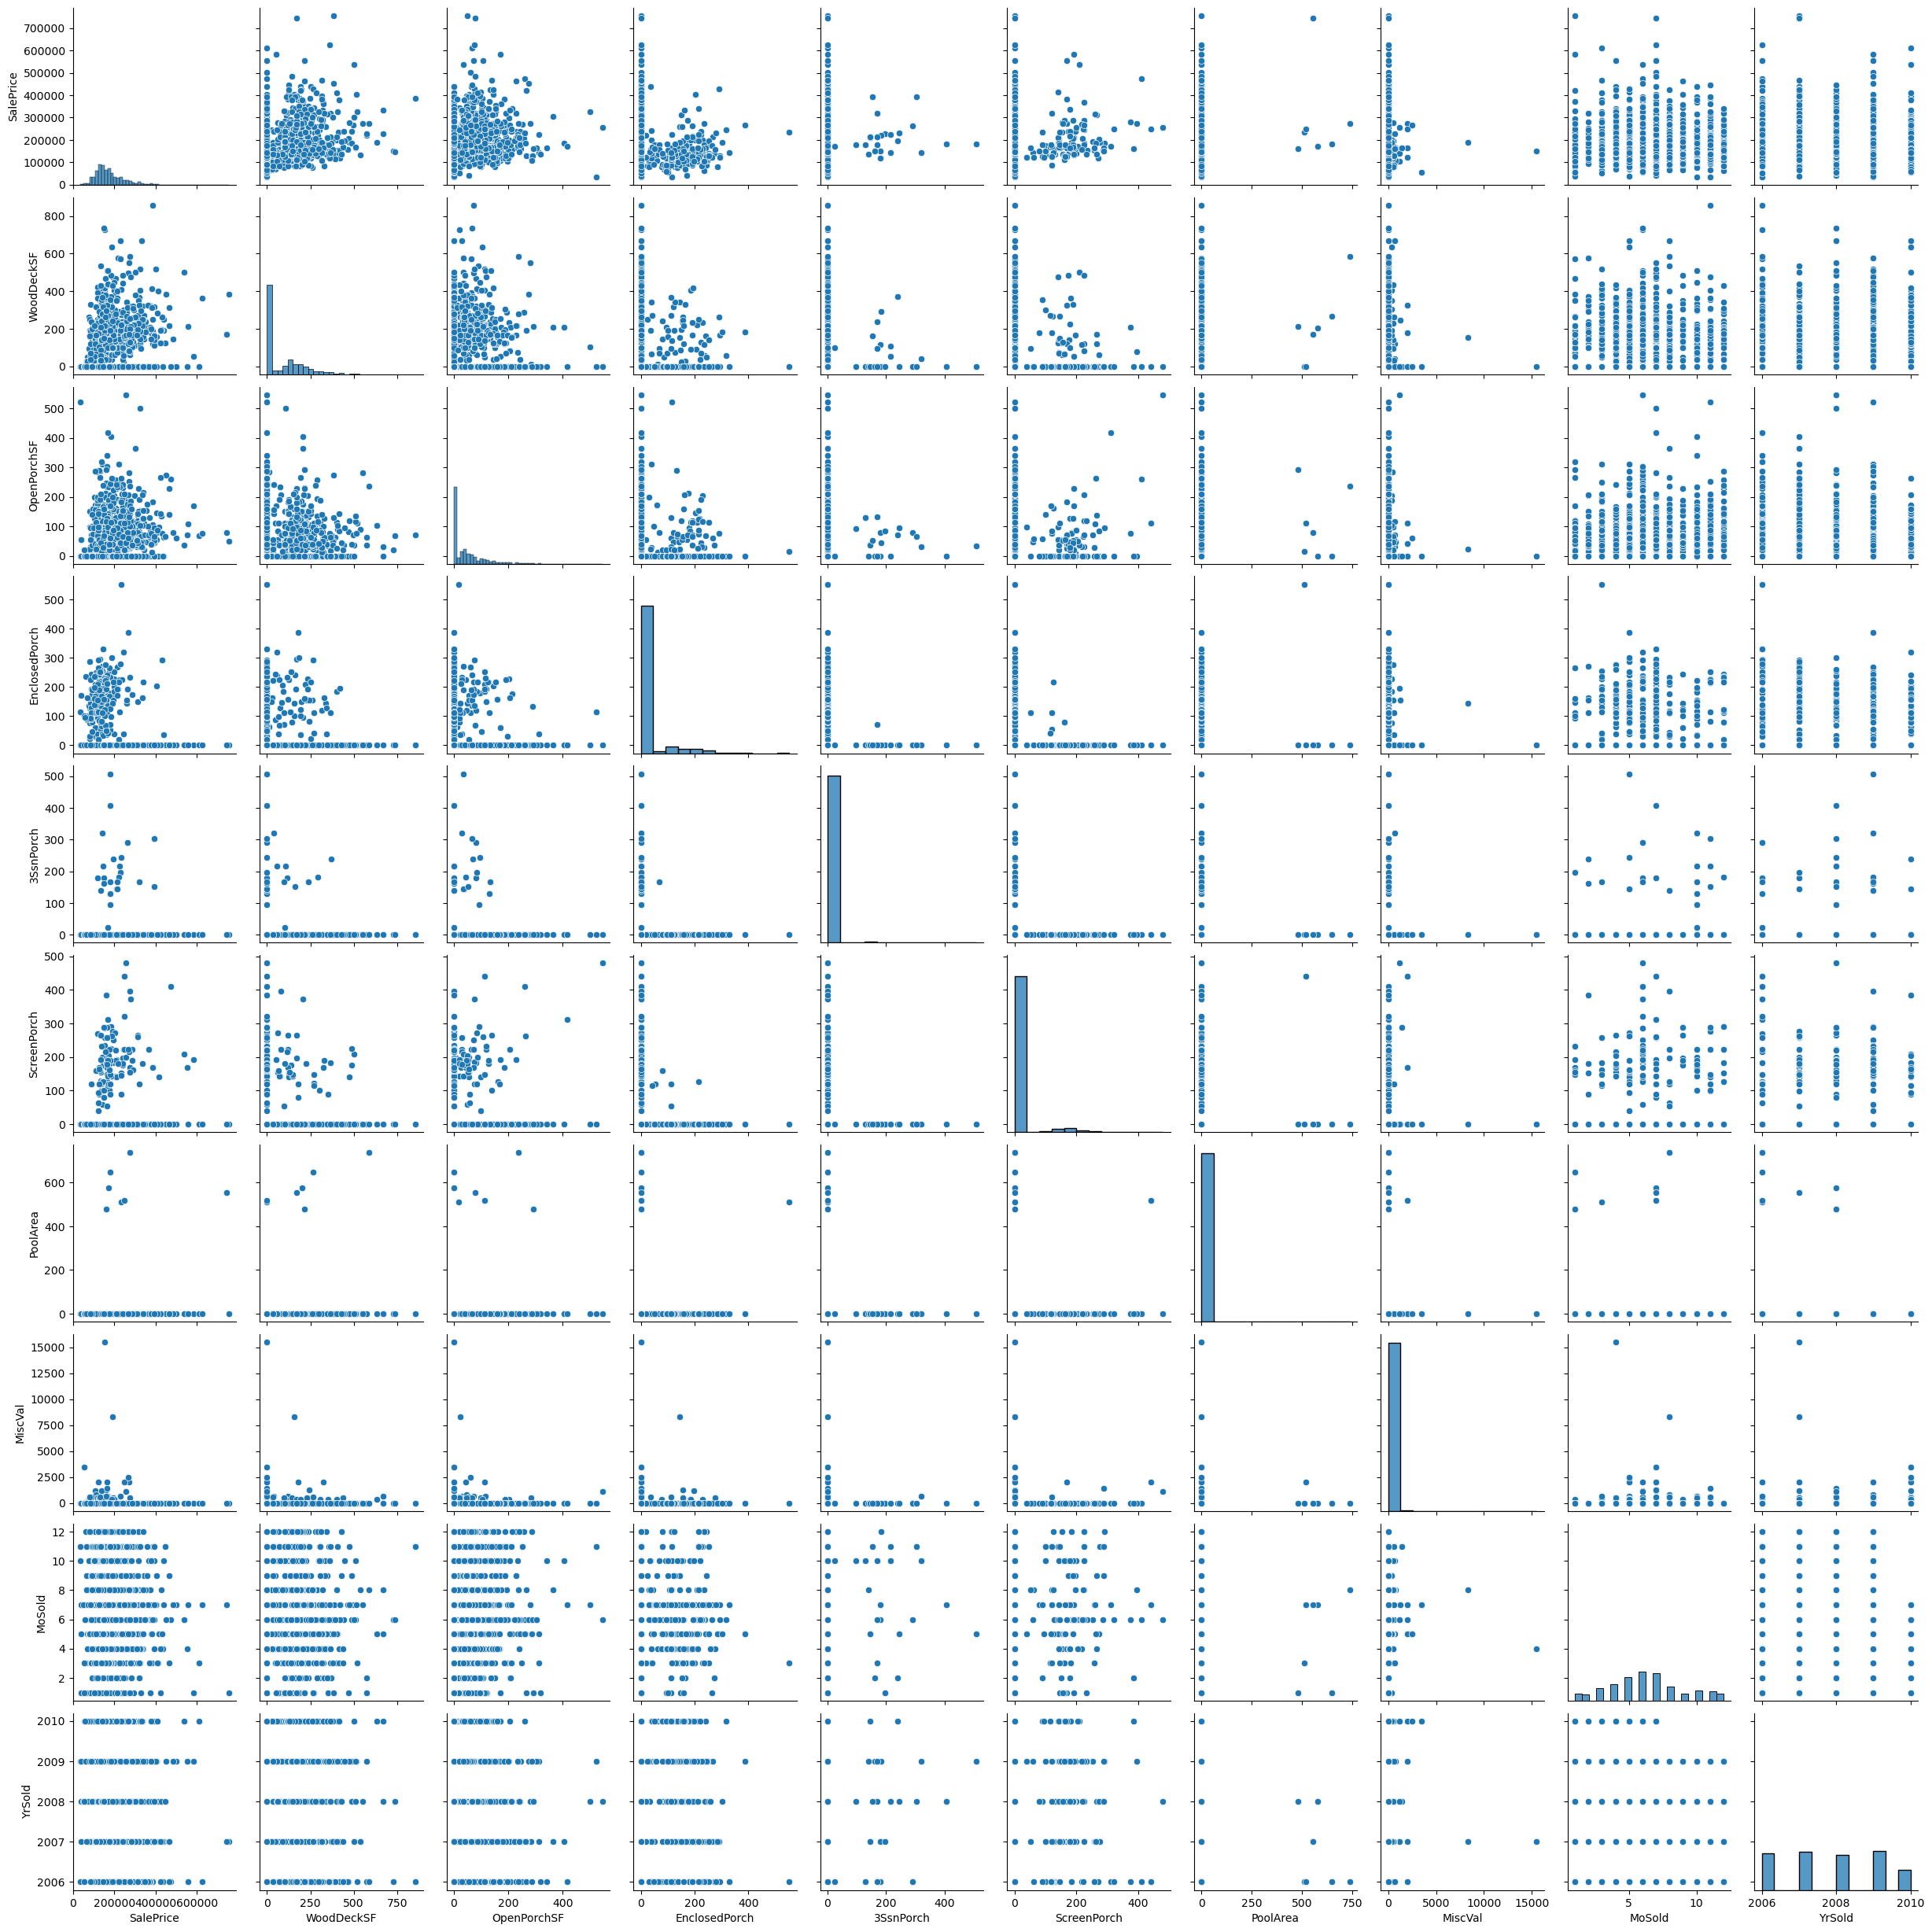

In [25]:
sns.pairplot(df[['SalePrice','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']])
plt.show()



Observations from PairPlots
- SalePrice shows upward trend with LotFrontage, LotArea, TotalBsmt, GarageArea, GarageCars, GrLivArea, TotalBsmtSF
- Because the high number of variables, we will need to use RFE to choose features and Lasso to choose the features further


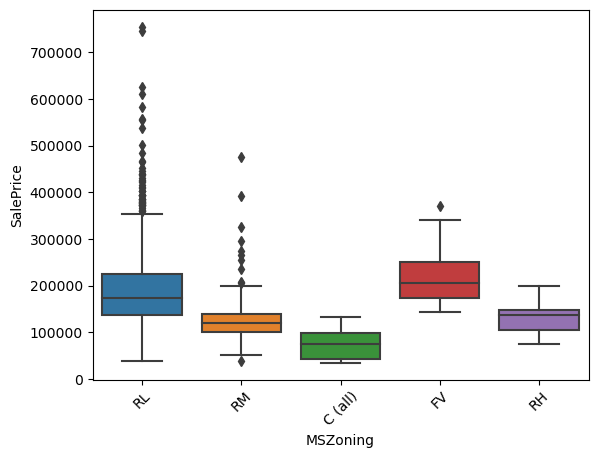

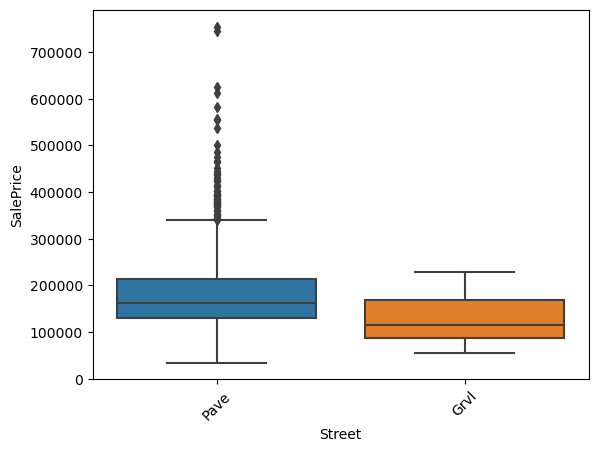

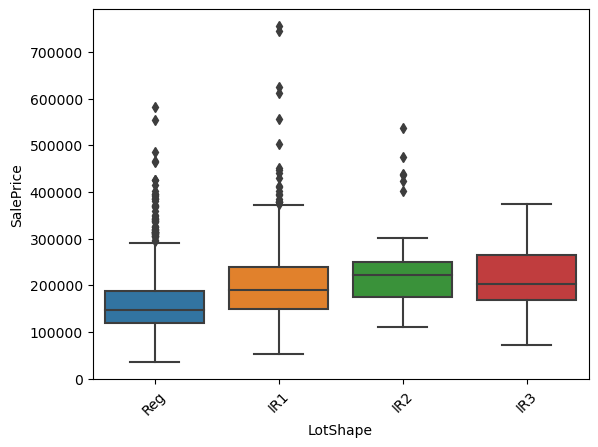

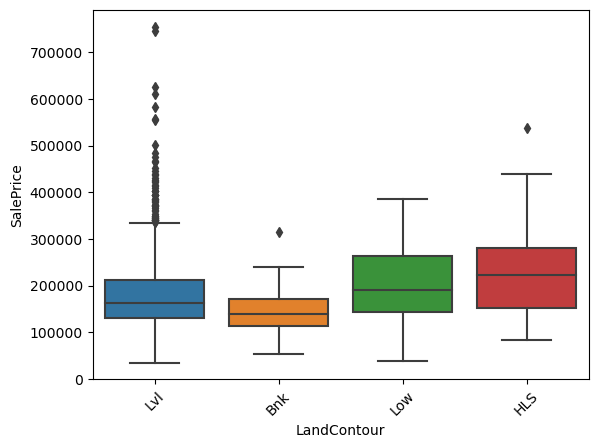

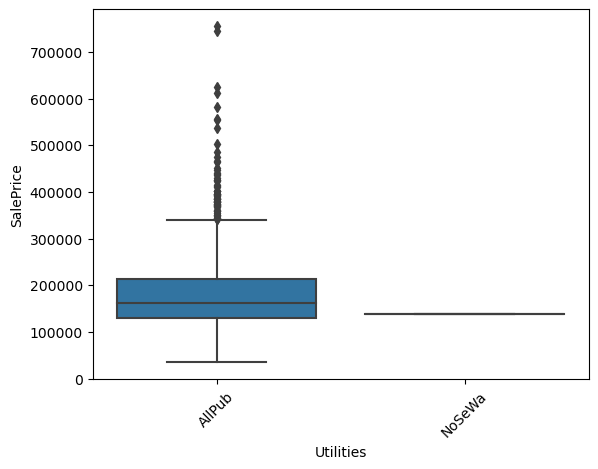

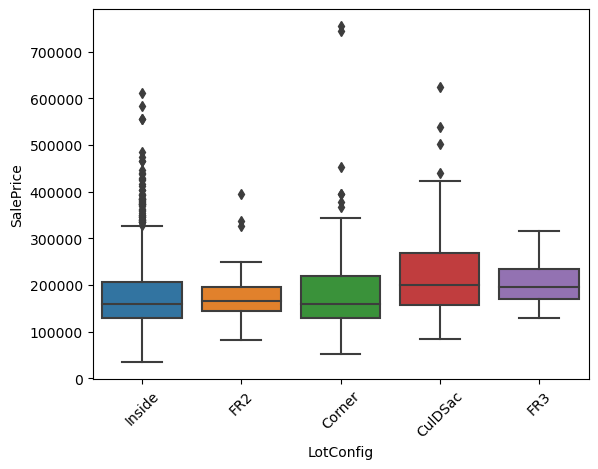

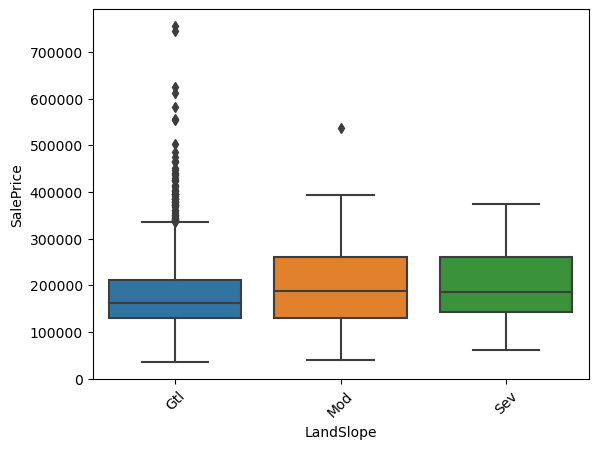

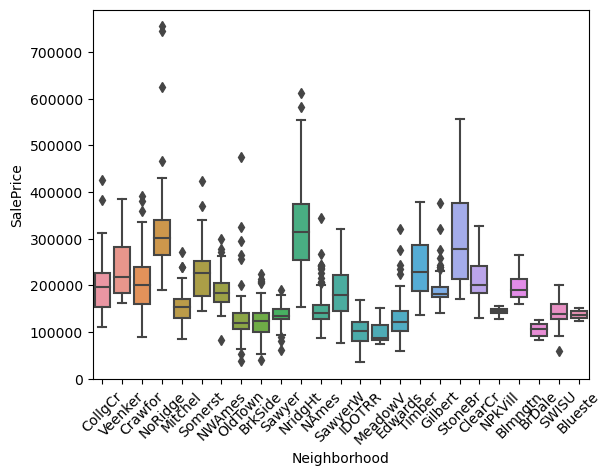

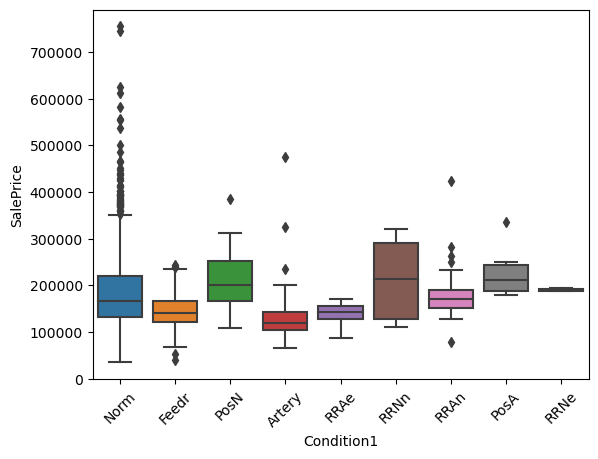

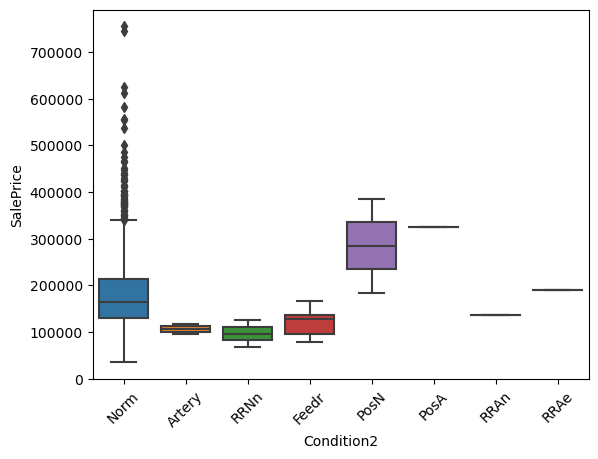

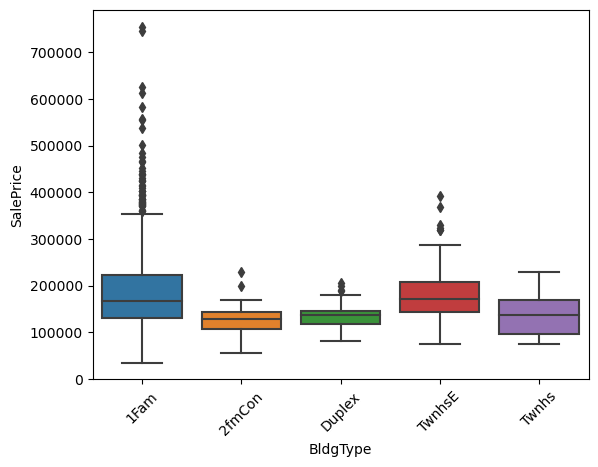

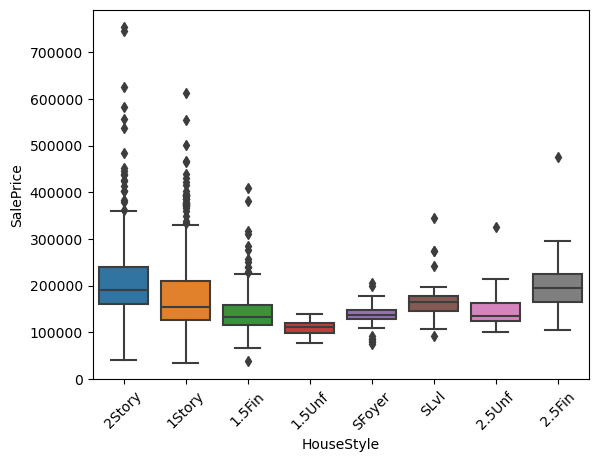

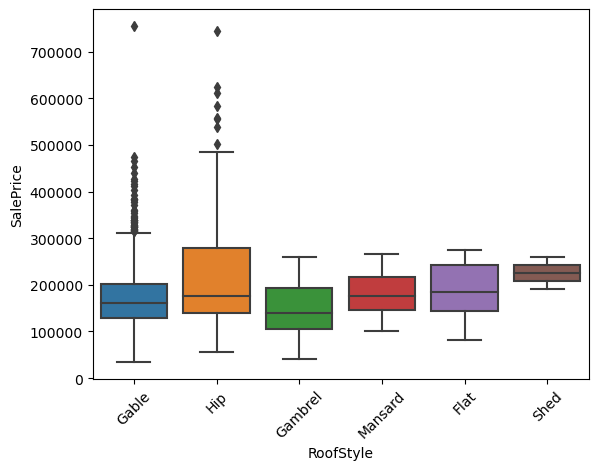

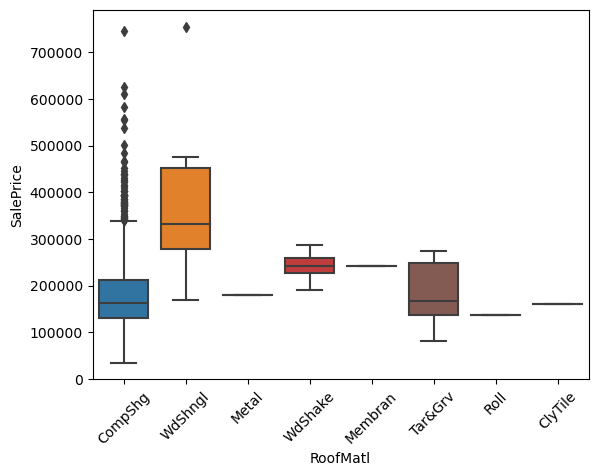

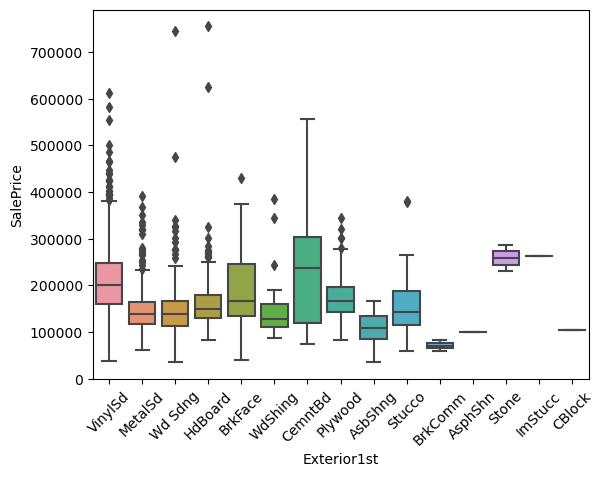

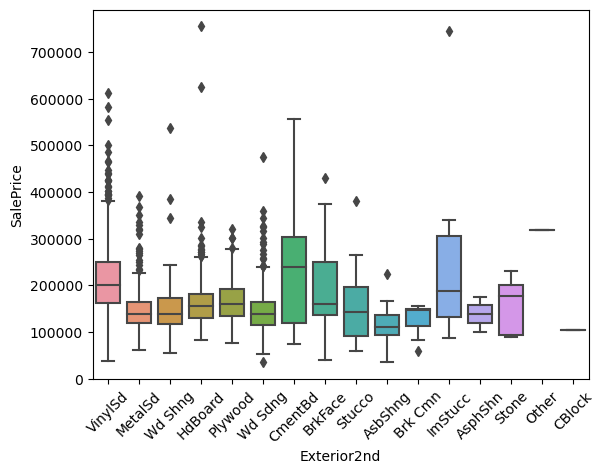

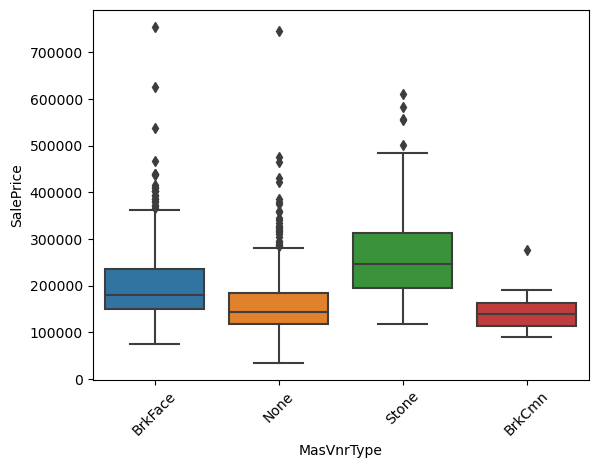

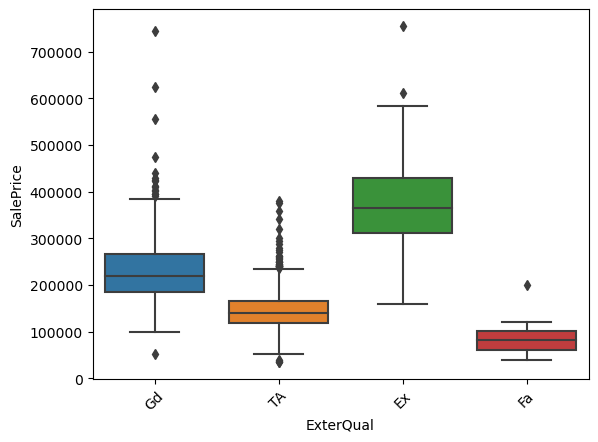

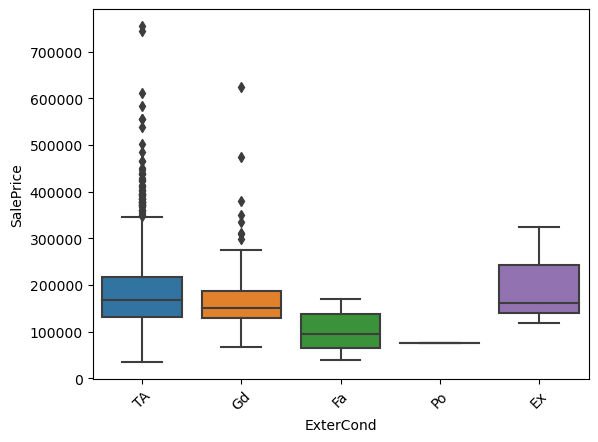

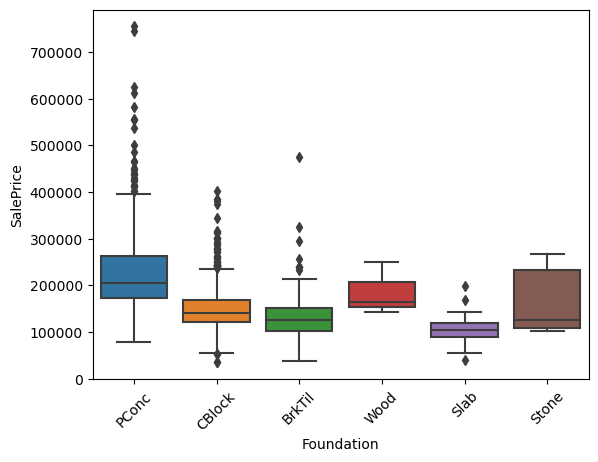

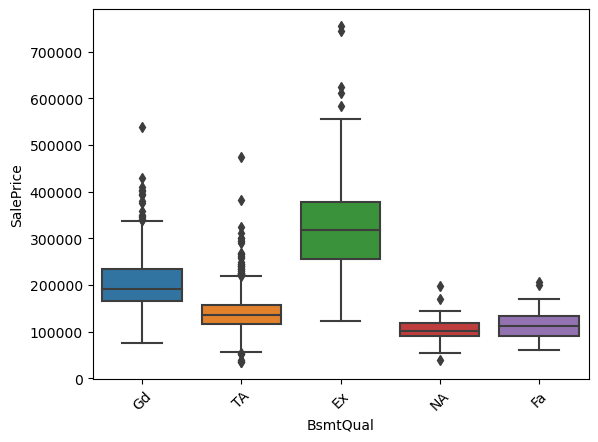

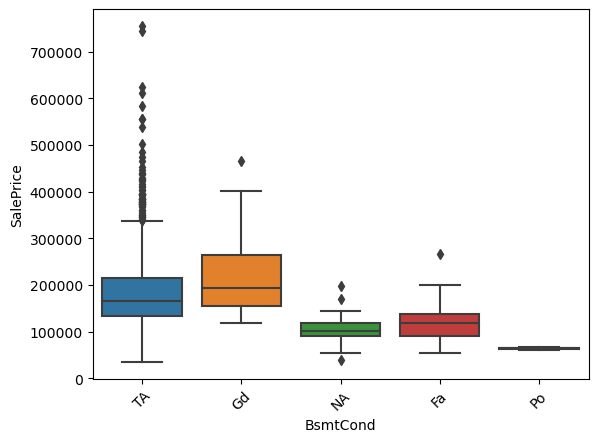

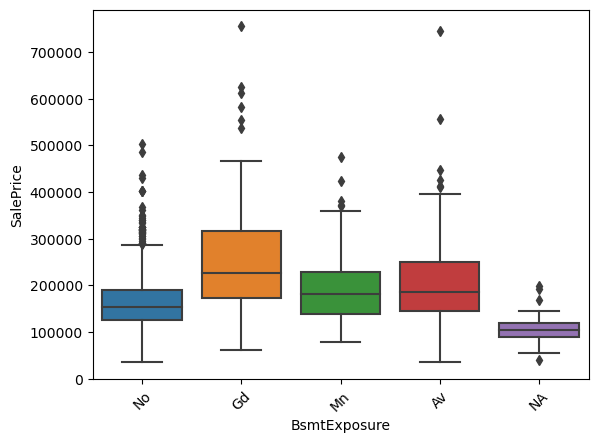

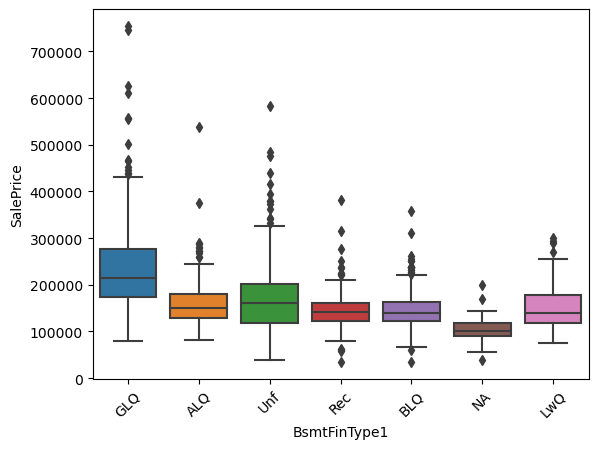

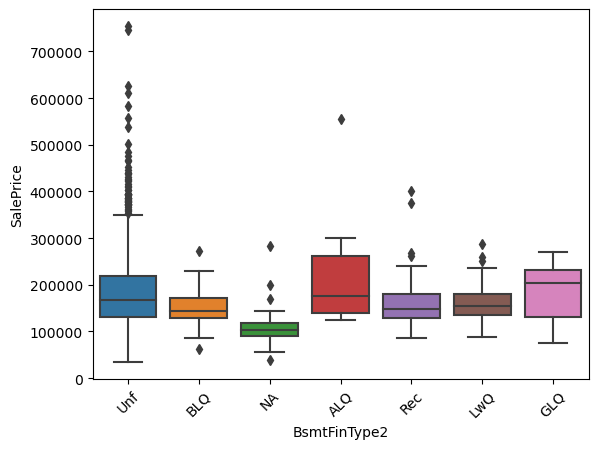

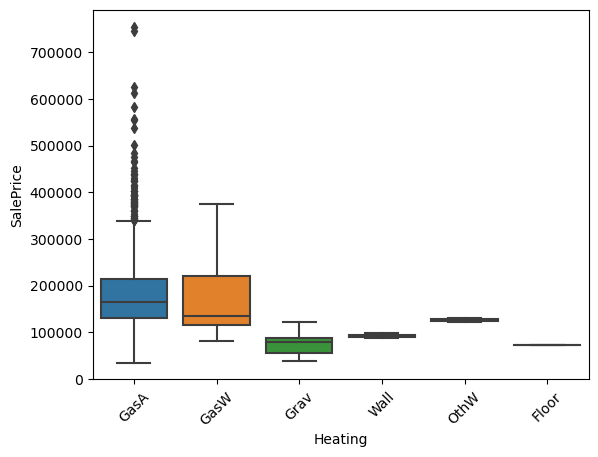

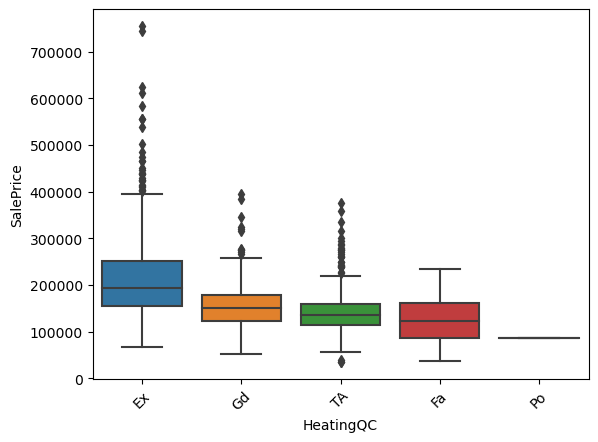

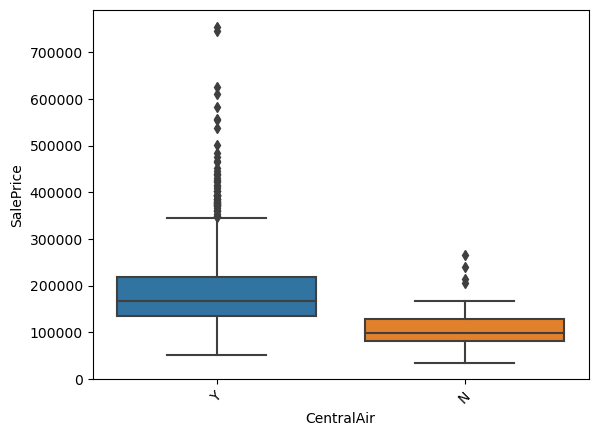

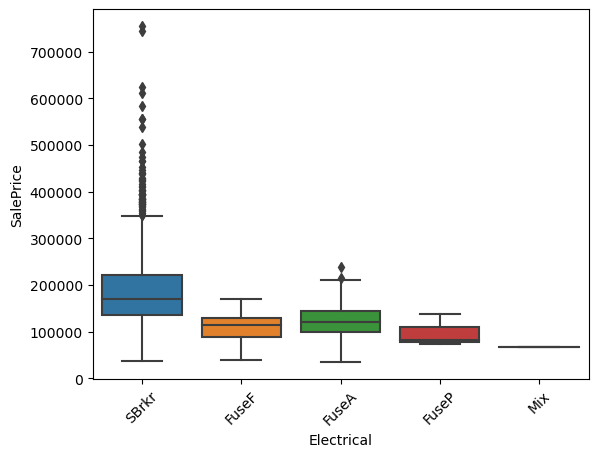

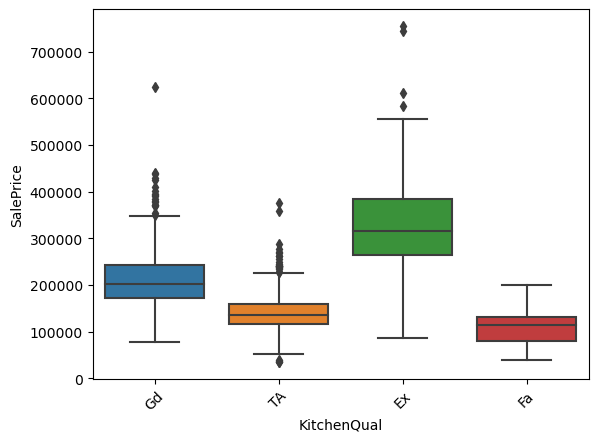

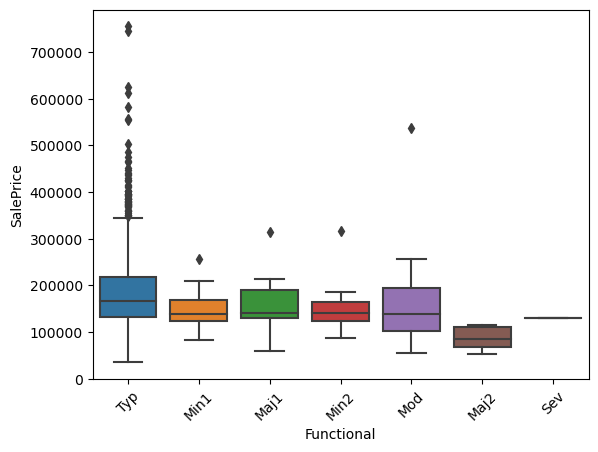

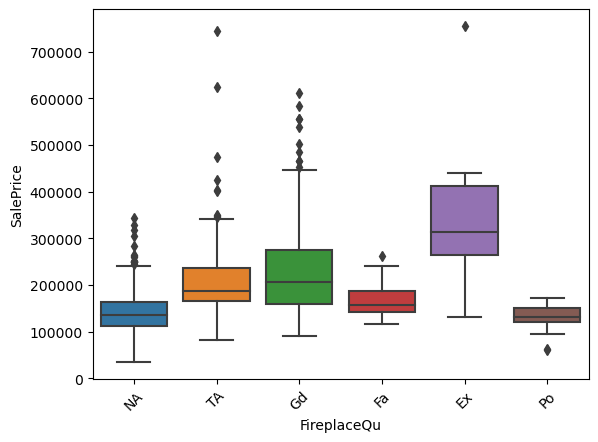

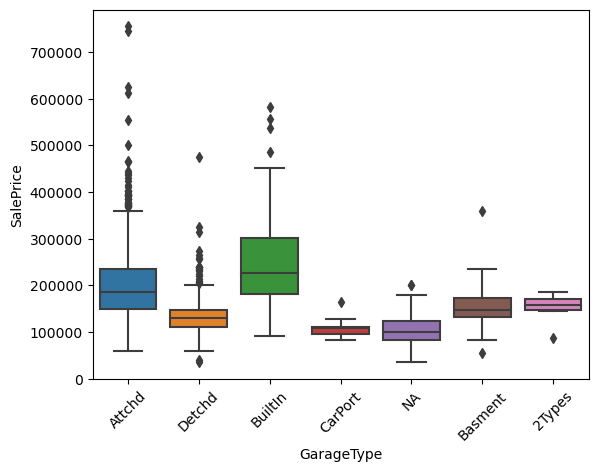

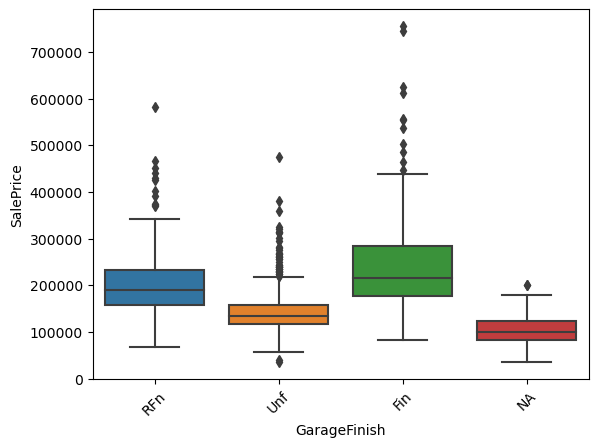

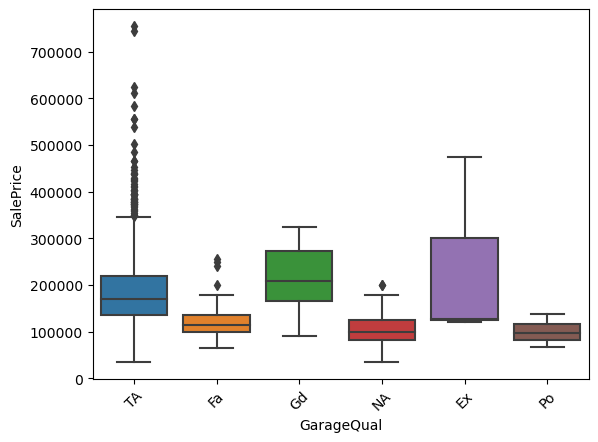

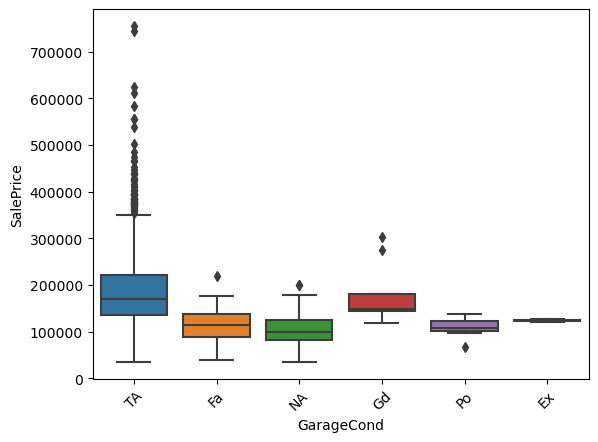

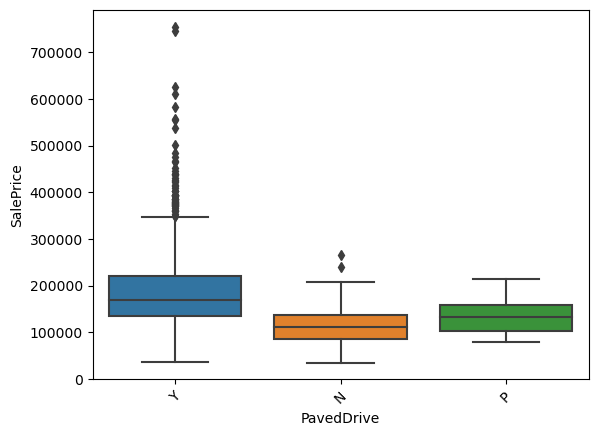

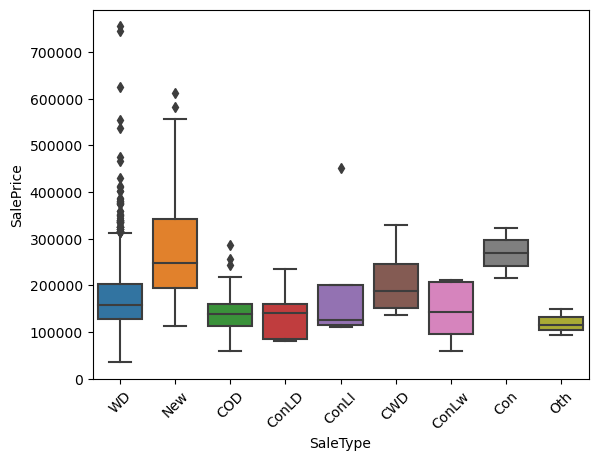

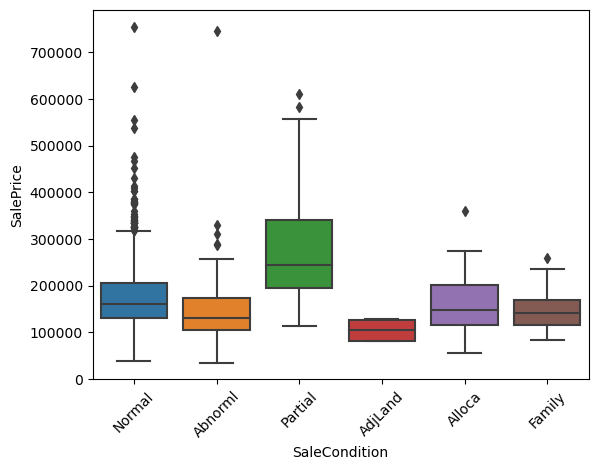

In [26]:
for cat_col in categorical_cols:
    ax=sns.boxplot(data=df,x=cat_col,y='SalePrice')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()

Observations for categorical variables - 
- For MSZoning FV, SalePrice is higher followed by RL
- For Paved Street the SalePrice is higher
- More irregular the LotShape, higher the price.
- With Public Utilities, SalePrice is higher
- CulDSac properties have higher price
- Certain neighbourhoods have higher SalesPrices e.g. Northridge and Stone Brook
- SalePrice is higher if it is closer to East West Rail Road
- SalePrice is higher if it is closer to a greenbelt
- When the roof material is WoodShingles, SalePrice is higher
- Masonry Vaneer Type 'Stone' has higher SalePrice
- SalePrice is higher when the exterior quality, exterior condition, basement quality, heating quality, kitchen quality, fireplace quality, garage quality is 'Excellent'
- Good quality Basement Finished area also drives the price of the property
- Central Air Conditioning also drives the SalePrice up
- Standard Circuit Board drives the SalesPrice up
- SalePrice is higher when the home is new.

## Data Preparation

For categorical variables, we need to encode and create dummy variables for them

In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
le = LabelEncoder()

In [29]:
le.fit(['NA','Po','Fa', 'TA', 'Gd', 'Ex'])

LabelEncoder()

In [30]:
le.classes_

array(['Ex', 'Fa', 'Gd', 'NA', 'Po', 'TA'], dtype='<U2')

In [31]:
## as per data dictionary, these columns have values that can be ordered and assigned a number

ordered_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']


In [32]:
##le.transform(df[ordered_cols[0]])

for ordered_col in ordered_cols:
    df[ordered_col] = le.transform(df[ordered_col])


In [33]:
## Let's check columns and their values
df[ordered_cols].describe()

ExterQual    ExterCond     BsmtQual     BsmtCond    HeatingQC  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean      3.780822     4.612329     3.169178     4.691096     1.832192   
std       1.602316     1.053269     1.736835     0.949616     2.163294   
min       0.000000     0.000000     0.000000     1.000000     0.000000   
25%       2.000000     5.000000     2.000000     5.000000     0.000000   
50%       5.000000     5.000000     2.000000     5.000000     0.000000   
75%       5.000000     5.000000     5.000000     5.000000     5.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

       KitchenQual  FireplaceQu   GarageQual   GarageCond  
count  1460.000000  1460.000000  1460.000000  1460.000000  
mean      3.346575     3.087671     4.716438     4.763014  
std       1.737904     1.167523     0.898787     0.802670  
min       0.000000     0.000000     0.000000     0.000000  
25%       2.000000     2.000000     5.000000     5.000000  
50%       5.000000     3.000000     5.000000     5.000000  
75%       5.000000     3.000000     5.000000     5.000000  
max       5.000000     5.000000     5.000000     5.000000

In [34]:
## let's filter ordered out of all columns
categorical_cols_unordered = list(set(categorical_cols) - set(ordered_cols))
categorical_cols_unordered

['Condition1',
 'LotShape',
 'BsmtFinType2',
 'Exterior1st',
 'Utilities',
 'BsmtExposure',
 'MasVnrType',
 'Heating',
 'MSZoning',
 'Foundation',
 'BldgType',
 'Condition2',
 'Street',
 'BsmtFinType1',
 'RoofStyle',
 'CentralAir',
 'GarageType',
 'RoofMatl',
 'PavedDrive',
 'LandContour',
 'SaleCondition',
 'Exterior2nd',
 'GarageFinish',
 'LandSlope',
 'Electrical',
 'Functional',
 'HouseStyle',
 'LotConfig',
 'SaleType',
 'Neighborhood']

In [35]:
# Let's get dummies for categorical variables

for cat_col in categorical_cols_unordered:
    df_dummy = pd.get_dummies(df[cat_col],prefix = cat_col ,drop_first=True)
    df = pd.concat([df,df_dummy],axis=1)
    df = df.drop([cat_col],axis=1)
    
df.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  ExterQual  ExterCond  ...  Neighborhood_NoRidge  \
0          2003       196.0          2          5  ...                     0   
1          1976         0.0          5          5  ...                     0   
2          2002       162.0          2          5  ...                     0   
3          1970         0.0          5          5  ...                     0   
4          2000       350.0          2          5  ...                     1   

   Neighborhood_NridgHt  Neighborhood_OldTown  Neighborhood_SWISU  \
0                     0                     0                   0   
1                     0                     0                   0   
2                     0                     0                   0   
3                     0                     0                   0   
4                     0                     0                   0   

   Neighborhood_Sawyer  Neighborhood_SawyerW  Neighborhood_Somerst  \
0                    0                     0                     0   
1                    0                     0                     0   
2                    0                     0                     0   
3                    0                     0                     0   
4                    0                     0                     0   

   Neighborhood_StoneBr  Neighborhood_Timber  Neighborhood_Veenker  
0                     0                    0                     0  
1                     0                    0                     1  
2                     0                    0                     0  
3                     0                    0                     0  
4                     0                    0                     0  

[5 rows x 219 columns]

In [36]:
df.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       ...
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker'],
      dtype='object', length=219)

#### As part of data preparation we followed below steps

- For ordinal categorical features, we used label encoding. 
- For nominal categorical features, we used encoding and created dummies. 

### Train-Test split

In [37]:
## Let's split the data in training and test set

from sklearn.model_selection import train_test_split

np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [38]:
## We will use MinMaxScaler for Linear Regression Model

lm_scaler = MinMaxScaler()

In [39]:
df_train[:] = lm_scaler.fit_transform(df_train[:])

In [40]:
df_train.head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
210     0.058824     0.214058  0.019306     0.444444        0.625   0.384058   
318     0.235294     0.287540  0.039403     0.666667        0.500   0.876812   
239     0.176471     0.166134  0.033981     0.555556        0.375   0.528986   
986     0.176471     0.188498  0.017931     0.555556        0.875   0.275362   
1416    1.000000     0.191693  0.046139     0.333333        0.625   0.094203   

      YearRemodAdd  MasVnrArea  ExterQual  ExterCond  ...  \
210       0.000000        0.00        1.0        1.0  ...   
318       0.716667        0.16        0.4        1.0  ...   
239       0.000000        0.00        1.0        1.0  ...   
986       0.883333        0.00        1.0        0.4  ...   
1416      0.000000        0.00        1.0        1.0  ...   

      Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_OldTown  \
210                    0.0                   0.0                   0.0   
318                    1.0                   0.0                   0.0   
239                    0.0                   0.0                   0.0   
986                    0.0                   0.0                   1.0   
1416                   0.0                   0.0                   1.0   

      Neighborhood_SWISU  Neighborhood_Sawyer  Neighborhood_SawyerW  \
210                  0.0                  0.0                   0.0   
318                  0.0                  0.0                   0.0   
239                  0.0                  0.0                   0.0   
986                  0.0                  0.0                   0.0   
1416                 0.0                  0.0                   0.0   

      Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  \
210                    0.0                   0.0                  0.0   
318                    0.0                   0.0                  0.0   
239                    0.0                   0.0                  0.0   
986                    0.0                   0.0                  0.0   
1416                   0.0                   0.0                  0.0   

      Neighborhood_Veenker  
210                    0.0  
318                    0.0  
239                    0.0  
986                    0.0  
1416                   0.0  

[5 rows x 219 columns]

In [41]:
df_train.describe()

MSSubClass  LotFrontage      LotArea  OverallQual  OverallCond  \
count  1021.000000  1021.000000  1021.000000  1021.000000  1021.000000   
mean      0.226134     0.183970     0.042143     0.565676     0.572723   
std       0.254755     0.109910     0.048226     0.155529     0.136506   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.137380     0.027923     0.444444     0.500000   
50%       0.176471     0.191693     0.037531     0.555556     0.500000   
75%       0.294118     0.249201     0.046943     0.666667     0.625000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         YearBuilt  YearRemodAdd   MasVnrArea    ExterQual    ExterCond  ...  \
count  1021.000000   1021.000000  1021.000000  1021.000000  1021.000000  ...   
mean      0.719215      0.582305     0.065306     0.756905     0.921058  ...   
std       0.219897      0.343843     0.117088     0.319718     0.211617  ...   
min       0.000000      0.000000     0.000000     0.000000     0.000000  ...   
25%       0.594203      0.283333     0.000000     0.400000     1.000000  ...   
50%       0.731884      0.733333     0.000000     1.000000     1.000000  ...   
75%       0.927536      0.900000     0.098750     1.000000     1.000000  ...   
max       1.000000      1.000000     1.000000     1.000000     1.000000  ...   

       Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_OldTown  \
count           1021.000000           1021.000000           1021.000000   
mean               0.033301              0.057786              0.077375   
std                0.179509              0.233454              0.267317   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                0.000000              0.000000              0.000000   
max                1.000000              1.000000              1.000000   

       Neighborhood_SWISU  Neighborhood_Sawyer  Neighborhood_SawyerW  \
count         1021.000000          1021.000000           1021.000000   
mean             0.018609             0.047992              0.044074   
std              0.135207             0.213854              0.205361   
min              0.000000             0.000000              0.000000   
25%              0.000000             0.000000              0.000000   
50%              0.000000             0.000000              0.000000   
75%              0.000000             0.000000              0.000000   
max              1.000000             1.000000              1.000000   

       Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  \
count           1021.000000           1021.000000          1021.000000   
mean               0.058766              0.012733             0.021548   
std                0.235301              0.112173             0.145272   
min                0.000000              0.000000             0.000000   
25%                0.000000              0.000000             0.000000   
50%                0.000000              0.000000             0.000000   
75%                0.000000              0.000000             0.000000   
max                1.000000              1.000000             1.000000   

       Neighborhood_Veenker  
count           1021.000000  
mean               0.010774  
std                0.103287  
min                0.000000  
25%                0.000000  
50%                0.000000  
75%                0.000000  
max                1.000000  

[8 rows x 219 columns]

In [42]:
y_train = df_train.pop('SalePrice')
X_train = df_train
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 210 to 79
Columns: 218 entries, MSSubClass to Neighborhood_Veenker
dtypes: float64(218)
memory usage: 1.7 MB


In [43]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 1021 entries, 210 to 79
Series name: SalePrice
Non-Null Count  Dtype  
--------------  -----  
1021 non-null   float64
dtypes: float64(1)
memory usage: 16.0 KB


In [44]:
# Running RFE with the output number of the variable equal to 10
lm_rfe = LinearRegression()
lm_rfe.fit(X_train, y_train)

rfe = RFE(lm_rfe,n_features_to_select=55)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [45]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 24),
 ('LotFrontage', False, 45),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 102),
 ('MasVnrArea', True, 1),
 ('ExterQual', True, 1),
 ('ExterCond', False, 97),
 ('BsmtQual', False, 21),
 ('BsmtCond', False, 139),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', True, 1),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('HeatingQC', False, 154),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 44),
 ('BsmtHalfBath', False, 121),
 ('FullBath', False, 85),
 ('HalfBath', False, 124),
 ('BedroomAbvGr', True, 1),
 ('KitchenAbvGr', True, 1),
 ('KitchenQual', False, 59),
 ('TotRmsAbvGrd', False, 61),
 ('Fireplaces', False, 74),
 ('FireplaceQu', False, 38),
 ('GarageYrBlt', True, 1),
 ('GarageCars', True, 1),
 ('GarageArea', False, 16),
 ('GarageQual', False, 103),
 ('GarageCond', False, 114),
 ('WoodDeckSF', False

In [46]:
## Grabbing the columns which has rfe.support_ as True
cols = X_train.columns[rfe.support_]
cols

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea',
       'ExterQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'PoolArea',
       'BsmtFinType2_NA', 'Exterior1st_AsphShn', 'Exterior1st_CBlock',
       'Exterior1st_CemntBd', 'Exterior1st_ImStucc', 'BsmtExposure_Gd',
       'Heating_OthW', 'Heating_Wall', 'Foundation_Wood', 'BldgType_Twnhs',
       'Condition2_PosN', 'Condition2_RRAe', 'Street_Pave', 'BsmtFinType1_NA',
       'RoofStyle_Shed', 'GarageType_NA', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'SaleCondition_Partial', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd',
       'GarageFinish_NA', 'LandSlope_Sev', 'Functional_Mod', 'Functional_Sev',
       'SaleType_Con', 'SaleType_New', 'Neighborhood_Crawfor',
 

In [47]:
## reducing columns to only RFE selected columns to make the model easier

X_train_rfe = X_train[cols]
y_train_rfe = y_train


In [48]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train_rfe, y_train_rfe)

LinearRegression()

In [49]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-1.4219042093461585
[ 0.19154512  0.117704    0.07568826  0.050893    0.03511547 -0.02417579
  0.23509941  0.02813746  0.02960744  0.23527637  0.1816785   0.12518086
 -0.03136595  0.19738588 -0.06531453 -0.08796728  0.2197466   0.04226716
  0.10067825 -0.08211255 -0.01167107 -0.01842889 -0.04938516 -0.03625221
  0.0266979  -0.07233499  0.04118035 -0.02782783 -0.03189393 -0.62574181
 -0.09727194  0.0507082   0.13519187  0.06392883  0.11769535  1.05284615
  1.16435122  1.10485102  1.04662385  1.05112729  1.02423286  1.13529057
  0.01772387 -0.01842889  0.05973364  0.11769535 -0.04177681 -0.04563288
 -0.12917443  0.05368032  0.01772387  0.03060139  0.03909867  0.03967371
  0.02109573]


In [50]:
## With RFE, we have total 123 features selected out of 247
len(lm.coef_)

55

In [51]:
df_test[:] = lm_scaler.transform(df_test[:])


In [52]:
y_test = df_test.pop('SalePrice')
X_test = df_test
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 1436 to 266
Columns: 218 entries, MSSubClass to Neighborhood_Veenker
dtypes: float64(218)
memory usage: 749.4 KB


In [53]:
X_test_rfe = X_test[cols]
y_test_rfe = y_test

In [54]:
y_pred_train = lm.predict(X_train_rfe)
y_pred_test = lm.predict(X_test_rfe)

In [55]:
metric = []

## r-squared for the train set

r2_train_lr = r2_score(y_train_rfe, y_pred_train)
print('R-squared for train set:',r2_train_lr)
metric.append(r2_train_lr)

## r-squared for test set

r2_test_lr = r2_score(y_test_rfe, y_pred_test)
print('R-squared for test set:',r2_test_lr)
metric.append(r2_test_lr)

## RSS for train set

rss1_lr = np.sum(np.square(y_train_rfe - y_pred_train))
print('RSS for train set:',rss1_lr)
metric.append(rss1_lr)

## RSS for test set 

rss2_lr = np.sum(np.square(y_test_rfe - y_pred_test))
print('RSS for test set:',rss2_lr)
metric.append(rss2_lr)


## MSE for train set 
mse_train_lr = mean_squared_error(y_train_rfe, y_pred_train)
print('MSE for train set:',mse_train_lr)
metric.append(mse_train_lr**0.5)

## MSE for test set
mse_test_lr = mean_squared_error(y_test_rfe, y_pred_test)
print('MSE for test set:',mse_test_lr)
metric.append(mse_test_lr**0.5)


R-squared for train set: 0.9140847327931534
R-squared for test set: 0.8062663474086149
RSS for train set: 1.057189807907487
RSS for test set: 1.0531014987712863
MSE for train set: 0.0010354454533863732
MSE for test set: 0.002404341321395631


## Observations for Linear Regression model

- After Label Encoding and Dummies for categorical features, we used MinMaxScaler 
- With RFE, we chose top 55 features 
- Based on this, we get R-squared for train-set as 0.91 and for test test, R-squared is 0.799. 
- Based on the difference between train and test scores, this is the case of overfitting. 


In [56]:
## Let's split the data in training and test set again
## We are doing this to again, so we can use StandardScaler and not MinMaxScaler

np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [57]:
scaler = StandardScaler()

In [58]:
df_train[:] = scaler.fit_transform(df_train[:])

In [59]:
y_train = df_train.pop('SalePrice')
X_train = df_train
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 210 to 79
Columns: 218 entries, MSSubClass to Neighborhood_Veenker
dtypes: float64(218)
memory usage: 1.7 MB


In [60]:
df_test[:] = scaler.transform(df_test[:])

In [61]:
y_test = df_test.pop('SalePrice')
X_test = df_test
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 1436 to 266
Columns: 218 entries, MSSubClass to Neighborhood_Veenker
dtypes: float64(218)
memory usage: 749.4 KB


## Ridge Regression

In [62]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [63]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [64]:
#Fitting Ridge model for alpha = 6.0 and printing coefficients which have been penalised
alpha = 500
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-3.82753969e-02  4.94369215e-03  3.62677618e-02  1.06375454e-01
  3.51965842e-02  1.84985373e-02  3.18401243e-02  5.09388655e-02
 -4.51555875e-02  2.89594914e-03 -5.24115294e-02  5.37061628e-03
  3.44056358e-02  9.74511353e-03  9.22725745e-03  4.74831719e-02
 -1.75660752e-02  7.04137636e-02  6.49734864e-02 -5.75401337e-03
  1.05317727e-01  3.07828925e-02  1.26984245e-03  4.58257751e-02
  2.53201061e-02  5.89288826e-03 -2.38175543e-02 -4.73116510e-02
  5.67324675e-02  4.77518361e-02 -2.72874126e-02 -3.30584316e-03
  5.57280398e-02  4.37365998e-02  3.53966137e-03  7.32364168e-03
  2.34439277e-02  1.58881064e-02  8.46508204e-04  1.30405724e-02
  1.35517722e-02  4.91289038e-04  5.15981920e-04 -3.40997881e-03
 -7.15860243e-03 -2.45619081e-02  2.48316824e-02  1.06103632e-02
 -2.22415426e-04 -1.40779408e-02  9.64062755e-03 -5.72575106e-03
 -8.25411382e-05  3.90422310e-03 -2.99217556e-02 -4.55128838e-03
 -9.89337477e-03  4.54891968e-03 -4.43646666e-03 -4.51811327e-03
 -7.14758412e-03 -1.99718

In [65]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

In [66]:
metric2 = []

## R-squared on train set
r2_train_ridge = r2_score(y_train, y_pred_train)
print('R-squared on train set:',r2_train_ridge)
metric2.append(r2_train_ridge)

## R-squared on test set
r2_test_ridge = r2_score(y_test, y_pred_test)
print('R-squared on test set:',r2_test_ridge)
metric2.append(r2_test_ridge)


## RSS for train set
rss1_ridge = np.sum(np.square(y_train - y_pred_train))
print('RSS for train set:',rss1_ridge)
metric2.append(rss1_ridge)


## RSS for test set
rss2_ridge = np.sum(np.square(y_test - y_pred_test))
print('RSS for test set:',rss2_ridge)
metric2.append(rss2_ridge)


mse_train_ridge = mean_squared_error(y_train, y_pred_train)
print('MSE for train set:',mse_train_ridge)
metric2.append(mse_train_ridge**0.5)


mse_test_ridge = mean_squared_error(y_test, y_pred_test)
print('MSE for test set:',mse_test_ridge)
metric2.append(mse_test_ridge**0.5)

R-squared on train set: 0.8801595066903635
R-squared on test set: 0.8546687227215024
RSS for train set: 122.35714366913888
RSS for test set: 65.54919678854715
MSE for train set: 0.11984049330963652
MSE for test set: 0.14965570043047294


## Observations for Ridge Regression:

 - R-squared for both train set and test set is comparable and hence model is more stable
 - R-squared on train set is 0.88 which is quite high and on test set it is 0.85. 
 - Although Ridge does not reduce the value of coeffiecinets to 0, we can choose important features by setting a threshold for the coefficients

## Lasso Regression

In [67]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [68]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.01}


In [69]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.01

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.01)

In [70]:
lasso.coef_

array([-9.17512814e-02, -0.00000000e+00,  4.29813142e-02,  1.98643856e-01,
        4.45015077e-02,  2.99297344e-02,  2.80582784e-02,  3.53275686e-02,
       -3.37459135e-02,  0.00000000e+00, -5.31585237e-02,  6.39770592e-03,
        1.72290518e-02,  0.00000000e+00, -0.00000000e+00,  1.40050801e-02,
       -8.81519121e-03,  0.00000000e+00,  0.00000000e+00, -1.46175915e-02,
        3.70360344e-01,  4.66169189e-02,  0.00000000e+00,  9.42651563e-03,
        0.00000000e+00, -0.00000000e+00, -2.34559633e-02, -3.78785939e-02,
        0.00000000e+00,  2.58375426e-02, -2.00867758e-02, -0.00000000e+00,
        8.32426994e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.29556760e-03,  1.54626354e-03, -0.00000000e+00,  4.10486856e-03,
        7.69669849e-03, -2.98890709e-03,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -1.97997853e-02,  2.78863296e-02,  4.05824897e-03,
        0.00000000e+00, -9.37089450e-03,  3.78518945e-03, -0.00000000e+00,
       -0.00000000e+00,  

In [71]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

In [72]:
metric3 = []

## R-squared for train set

r2_train_lasso = r2_score(y_train, y_pred_train)
print('R-squared for train set:',r2_train_lasso)
metric3.append(r2_train_lasso)

## R-squared for test set
r2_test_lasso = r2_score(y_test, y_pred_test)
print('R-squared for test set:',r2_test_lasso)
metric3.append(r2_test_lasso)

## RSS for train set
rss1_lasso = np.sum(np.square(y_train - y_pred_train))
print('RSS for train set:',rss1_lasso)
metric3.append(rss1_lasso)

## RSS for test set
rss2_lasso = np.sum(np.square(y_test - y_pred_test))
print('RSS for test set:',rss2_lasso)
metric3.append(rss2_lasso)

## MSE for train set
mse_train_lasso = mean_squared_error(y_train, y_pred_train)
print('MSE for train set:',mse_train_lasso)
metric3.append(mse_train_lasso**0.5)

## MSE for test set 
mse_test_lasso = mean_squared_error(y_test, y_pred_test)
print('MSE for test set:',mse_test_lasso)
metric3.append(mse_test_lasso**0.5)

R-squared for train set: 0.8899947942856152
R-squared for test set: 0.8405702329666069
RSS for train set: 112.31531503438688
RSS for test set: 71.9080804140865
MSE for train set: 0.11000520571438481
MSE for test set: 0.16417369957553996


## Observations for Lasso Regression - 
 - We can see that coefficients for several features is 0 and hence we can use Lasso for feature selection
 - R-squared for train and test are comparable and have only 0.04 points of difference. However, Ridge is doing better in terms of difference between R-squared for train and test set. 

In [73]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)           0.914085          0.880160          0.889995
1   R2 Score (Test)           0.806266          0.854669          0.840570
2       RSS (Train)           1.057190        122.357144        112.315315
3        RSS (Test)           1.053101         65.549197         71.908080
4       MSE (Train)           0.032178          0.346180          0.331670
5        MSE (Test)           0.049034          0.386854          0.405184

### Compare Coeffiecients for Ridge and Lasso

In [74]:
betas = pd.DataFrame(index=X_train.columns)

In [75]:
betas.rows = X_train.columns

In [76]:
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [77]:
pd.set_option('display.max_rows', None)
betas

Ridge     Lasso
MSSubClass            -0.038275 -0.091751
LotFrontage            0.004944 -0.000000
LotArea                0.036268  0.042981
OverallQual            0.106375  0.198644
OverallCond            0.035197  0.044502
YearBuilt              0.018499  0.029930
YearRemodAdd           0.031840  0.028058
MasVnrArea             0.050939  0.035328
ExterQual             -0.045156 -0.033746
ExterCond              0.002896  0.000000
BsmtQual              -0.052412 -0.053159
BsmtCond               0.005371  0.006398
BsmtFinSF1             0.034406  0.017229
BsmtFinSF2             0.009745  0.000000
BsmtUnfSF              0.009227 -0.000000
TotalBsmtSF            0.047483  0.014005
HeatingQC             -0.017566 -0.008815
1stFlrSF               0.070414  0.000000
2ndFlrSF               0.064973  0.000000
LowQualFinSF          -0.005754 -0.014618
GrLivArea              0.105318  0.370360
BsmtFullBath           0.030783  0.046617
BsmtHalfBath           0.001270  0.000000
FullBath               0.045826  0.009427
HalfBath               0.025320  0.000000
BedroomAbvGr           0.005893 -0.000000
KitchenAbvGr          -0.023818 -0.023456
KitchenQual           -0.047312 -0.037879
TotRmsAbvGrd           0.056732  0.000000
Fireplaces             0.047752  0.025838
FireplaceQu           -0.027287 -0.020087
GarageYrBlt           -0.003306 -0.000000
GarageCars             0.055728  0.083243
GarageArea             0.043737  0.000000
GarageQual             0.003540  0.000000
GarageCond             0.007324  0.000000
WoodDeckSF             0.023444  0.008296
OpenPorchSF            0.015888  0.001546
EnclosedPorch          0.000847 -0.000000
3SsnPorch              0.013041  0.004105
ScreenPorch            0.013552  0.007697
PoolArea               0.000491 -0.002989
MiscVal                0.000516  0.000000
MoSold                -0.003410 -0.000000
YrSold                -0.007159 -0.000000
Condition1_Feedr      -0.024562 -0.019800
Condition1_Norm        0.024832  0.027886
Condition1_PosA        0.010610  0.004058
Condition1_PosN       -0.000222  0.000000
Condition1_RRAe       -0.014078 -0.009371
Condition1_RRAn        0.009641  0.003785
Condition1_RRNe       -0.005726 -0.000000
Condition1_RRNn       -0.000083 -0.000000
LotShape_IR2           0.003904  0.000000
LotShape_IR3          -0.029922 -0.035231
LotShape_Reg          -0.004551  0.000000
BsmtFinType2_BLQ      -0.009893 -0.003065
BsmtFinType2_GLQ       0.004549  0.000000
BsmtFinType2_LwQ      -0.004436 -0.000000
BsmtFinType2_NA       -0.004518 -0.000000
BsmtFinType2_Rec      -0.007148 -0.000000
BsmtFinType2_Unf      -0.001997  0.000000
Exterior1st_AsphShn   -0.001389 -0.000000
Exterior1st_BrkComm   -0.003955 -0.000000
Exterior1st_BrkFace    0.022661  0.026407
Exterior1st_CBlock    -0.002122 -0.000000
Exterior1st_CemntBd    0.008832  0.000000
Exterior1st_HdBoard   -0.006274 -0.000000
Exterior1st_ImStucc   -0.010285 -0.005040
Exterior1st_MetalSd    0.000886  0.000000
Exterior1st_Plywood   -0.007932 -0.000000
Exterior1st_Stone      0.003855  0.000000
Exterior1st_Stucco    -0.008596 -0.001298
Exterior1st_VinylSd    0.004089  0.000000
Exterior1st_Wd Sdng   -0.001772 -0.000000
Exterior1st_WdShing    0.004887  0.000000
Utilities_NoSeWa      -0.011501 -0.006761
BsmtExposure_Gd        0.055586  0.078958
BsmtExposure_Mn       -0.009215 -0.002332
BsmtExposure_NA       -0.005895 -0.009511
BsmtExposure_No       -0.038278 -0.035931
MasVnrType_BrkFace    -0.005207 -0.000000
MasVnrType_None        0.005473  0.010723
MasVnrType_Stone       0.003167 -0.000000
Heating_GasA          -0.004973 -0.000000
Heating_GasW           0.009203  0.004469
Heating_Grav          -0.002306 -0.000000
Heating_OthW          -0.008568 -0.016128
Heating_Wall           0.001776  0.000000
MSZoning_FV            0.005165  0.000000
MSZoning_RH            0.002934  0.000000
MSZoning_RL            0.015783  0.017297
MSZoning_RM           -0.009766 -0.000000
Foundation_CBlock      0.000049  0.000000
Foundation_PConc       0.011915  0.0

#### For Lasso, below is the list of coefficients

In [78]:
betas[ abs(betas['Lasso'])>0]['Lasso'].sort_values(ascending=False)

GrLivArea                0.370360
OverallQual              0.198644
Neighborhood_NridgHt     0.110469
Neighborhood_NoRidge     0.092385
GarageCars               0.083243
RoofMatl_WdShngl         0.082059
BsmtExposure_Gd          0.078958
RoofMatl_CompShg         0.048639
BsmtFullBath             0.046617
OverallCond              0.044502
Neighborhood_Somerst     0.044396
LotArea                  0.042981
SaleCondition_Partial    0.040929
Neighborhood_Crawfor     0.040176
MasVnrArea               0.035328
YearBuilt                0.029930
Neighborhood_StoneBr     0.029876
LotConfig_CulDSac        0.029341
YearRemodAdd             0.028058
Condition1_Norm          0.027886
Exterior1st_BrkFace      0.026407
Fireplaces               0.025838
Functional_Typ           0.023400
Exterior2nd_CmentBd      0.023294
Exterior2nd_ImStucc      0.018784
MSZoning_RL              0.017297
BsmtFinSF1               0.017229
BsmtFinType1_GLQ         0.014104
TotalBsmtSF              0.014005
HouseStyle_1St

In [79]:
betas[ abs(betas['Ridge'])>0 ]['Ridge'].sort_values(ascending=False)

OverallQual              0.106375
GrLivArea                0.105318
Neighborhood_NoRidge     0.077492
1stFlrSF                 0.070414
Neighborhood_NridgHt     0.067806
2ndFlrSF                 0.064973
RoofMatl_WdShngl         0.064448
TotRmsAbvGrd             0.056732
GarageCars               0.055728
BsmtExposure_Gd          0.055586
MasVnrArea               0.050939
Fireplaces               0.047752
TotalBsmtSF              0.047483
FullBath                 0.045826
GarageArea               0.043737
LotArea                  0.036268
OverallCond              0.035197
BsmtFinSF1               0.034406
BsmtFinType1_GLQ         0.033697
Neighborhood_Crawfor     0.033249
YearRemodAdd             0.031840
BsmtFullBath             0.030783
Neighborhood_StoneBr     0.028312
Exterior2nd_ImStucc      0.027590
LotConfig_CulDSac        0.026755
HalfBath                 0.025320
Condition1_Norm          0.024832
RoofMatl_CompShg         0.023878
WoodDeckSF               0.023444
Exterior1st_Br

In [80]:
betas[ abs(betas['Lasso'])>0.01]['Lasso'].sort_values(ascending=False)

GrLivArea                0.370360
OverallQual              0.198644
Neighborhood_NridgHt     0.110469
Neighborhood_NoRidge     0.092385
GarageCars               0.083243
RoofMatl_WdShngl         0.082059
BsmtExposure_Gd          0.078958
RoofMatl_CompShg         0.048639
BsmtFullBath             0.046617
OverallCond              0.044502
Neighborhood_Somerst     0.044396
LotArea                  0.042981
SaleCondition_Partial    0.040929
Neighborhood_Crawfor     0.040176
MasVnrArea               0.035328
YearBuilt                0.029930
Neighborhood_StoneBr     0.029876
LotConfig_CulDSac        0.029341
YearRemodAdd             0.028058
Condition1_Norm          0.027886
Exterior1st_BrkFace      0.026407
Fireplaces               0.025838
Functional_Typ           0.023400
Exterior2nd_CmentBd      0.023294
Exterior2nd_ImStucc      0.018784
MSZoning_RL              0.017297
BsmtFinSF1               0.017229
BsmtFinType1_GLQ         0.014104
TotalBsmtSF              0.014005
HouseStyle_1St

## For Ridge, below is the list of significant features 

In [81]:
betas[ abs(betas['Ridge'])>0.01 ]['Ridge'].sort_values(ascending=False)

OverallQual              0.106375
GrLivArea                0.105318
Neighborhood_NoRidge     0.077492
1stFlrSF                 0.070414
Neighborhood_NridgHt     0.067806
2ndFlrSF                 0.064973
RoofMatl_WdShngl         0.064448
TotRmsAbvGrd             0.056732
GarageCars               0.055728
BsmtExposure_Gd          0.055586
MasVnrArea               0.050939
Fireplaces               0.047752
TotalBsmtSF              0.047483
FullBath                 0.045826
GarageArea               0.043737
LotArea                  0.036268
OverallCond              0.035197
BsmtFinSF1               0.034406
BsmtFinType1_GLQ         0.033697
Neighborhood_Crawfor     0.033249
YearRemodAdd             0.031840
BsmtFullBath             0.030783
Neighborhood_StoneBr     0.028312
Exterior2nd_ImStucc      0.027590
LotConfig_CulDSac        0.026755
HalfBath                 0.025320
Condition1_Norm          0.024832
RoofMatl_CompShg         0.023878
WoodDeckSF               0.023444
Exterior1st_Br

## Features driving the sales price 
In both Ridge and Lasso, we see similar features driving the SalesPrice - 
- OverallQual - Overall material and finish of the house
- GrLivArea - Above grade (ground) living area square feet
- 1stFlrSF, 2ndFlrSF - First and Second floor square feet
- Neighborhood_NoRidge, Neighborhood_NridgHt, Neighborhood_StoneBr , Neighborhood_Crawfor 
   Properties in the neighbourhoods like - Northridge, Northridge Heights, Stone Brook, Crawford
- RoofMatl_WdShngl - Roof Material is Wood Shingles
- GarageCars - Size of the car capacity
- BsmtExposure as Good.
- MasVnrType - Masonry veneer type
- Fireplaces
- TotalBsmtSF - Total Basement Square Feet
- FullBath - Full bathrooms above grade
- GarageArea
- LotArea - Lot size in square feet
- ExterQual - Exterrior Quality
- KitchenQual - Kitchen Quality
- BsmtQual - Basement Quality
- Condition2 as PosN - Near positive off-site feature--park, greenbelt, etc.
- OverallCond - Overall Condition of the house
- BsmtFinSF1 - Type 1 finished square

## Assignment Part II

## Q1:  Doubling the value of the alpha for Ridge and Lasso

### Ridge

Alpha for Ridge as per above is - 500. We will double it here to 1000 for the Ridge 


In [82]:
alpha = 1000
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-2.80359516e-02  9.70826998e-03  3.03863955e-02  8.83842685e-02
  2.57570052e-02  1.86295533e-02  3.13327139e-02  4.59435301e-02
 -4.53181283e-02  1.83161989e-03 -4.60177258e-02  5.63392822e-03
  3.41383395e-02  7.87012520e-03  1.06291656e-02  4.78847427e-02
 -1.91495312e-02  6.24675041e-02  4.96026275e-02 -4.16048353e-03
  8.69408983e-02  2.65582064e-02  8.05110456e-04  4.25923324e-02
  2.51374426e-02  1.08207401e-02 -1.91012236e-02 -4.71912199e-02
  5.33978231e-02  4.77486535e-02 -2.36685162e-02  8.55120593e-04
  4.93447931e-02  4.51237042e-02  3.86164450e-03  8.47938965e-03
  2.57416080e-02  1.66915338e-02  3.25626723e-04  9.94459692e-03
  1.25451159e-02  2.92920483e-03 -1.52952345e-04 -1.14740946e-03
 -5.64046760e-03 -1.95771528e-02  2.03259925e-02  8.71290452e-03
 -2.49323500e-03 -1.07351561e-02  5.65731073e-03 -4.64847344e-03
 -8.05689865e-04  4.76066047e-03 -2.13136820e-02 -1.02176796e-02
 -6.45049741e-03  4.05918135e-03 -3.61884411e-03 -4.36946379e-03
 -5.01203269e-03 -3.58759

In [83]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

In [84]:
metric4 = []

## R-squared on train set
r2_train_ridge = r2_score(y_train, y_pred_train)
print('R-squared on train set:',r2_train_ridge)
metric4.append(r2_train_ridge)

## R-squared on test set
r2_test_ridge = r2_score(y_test, y_pred_test)
print('R-squared on test set:',r2_test_ridge)
metric4.append(r2_test_ridge)


## RSS for train set
rss1_ridge = np.sum(np.square(y_train - y_pred_train))
print('RSS for train set:',rss1_ridge)
metric4.append(rss1_ridge)


## RSS for test set
rss2_ridge = np.sum(np.square(y_test - y_pred_test))
print('RSS for test set:',rss2_ridge)
metric4.append(rss2_ridge)


mse_train_ridge = mean_squared_error(y_train, y_pred_train)
print('MSE for train set:',mse_train_ridge)
metric4.append(mse_train_ridge**0.5)


mse_test_ridge = mean_squared_error(y_test, y_pred_test)
print('MSE for test set:',mse_test_ridge)
metric4.append(mse_test_ridge**0.5)

R-squared on train set: 0.8586512895057329
R-squared on test set: 0.8443068678975305
RSS for train set: 144.31703341464674
RSS for test set: 70.22273488488769
MSE for train set: 0.14134871049426714
MSE for test set: 0.16032587873262028


## Lasso

Alpha for Lasso is 0.01 and we will double this to 0.02

In [85]:
alpha =0.02
lasso = Lasso(alpha=alpha)        
lasso.fit(X_train, y_train) 
lasso.coef_

array([-0.08387091, -0.        ,  0.03236833,  0.22462113,  0.03236875,
        0.03311898,  0.03438293,  0.0284819 , -0.03493923,  0.        ,
       -0.05192762,  0.00090496,  0.01841808,  0.        , -0.        ,
        0.03595373, -0.00459441,  0.        ,  0.        , -0.00763994,
        0.33883953,  0.0413333 ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.01891438, -0.04229447,  0.        ,  0.03036993,
       -0.01134061, -0.        ,  0.08314235,  0.        ,  0.        ,
        0.        ,  0.00796624,  0.        , -0.        ,  0.        ,
        0.00064584, -0.        ,  0.        , -0.        , -0.        ,
       -0.01171701,  0.02469163,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.02464319,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.02308388,
       -0.        ,  0.        , -0.        , -0.        ,  0.  

In [86]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

In [87]:
metric5 = []

## R-squared for train set

r2_train_lasso = r2_score(y_train, y_pred_train)
print('R-squared for train set:',r2_train_lasso)
metric5.append(r2_train_lasso)

## R-squared for test set
r2_test_lasso = r2_score(y_test, y_pred_test)
print('R-squared for test set:',r2_test_lasso)
metric5.append(r2_test_lasso)

## RSS for train set
rss1_lasso = np.sum(np.square(y_train - y_pred_train))
print('RSS for train set:',rss1_lasso)
metric5.append(rss1_lasso)

## RSS for test set
rss2_lasso = np.sum(np.square(y_test - y_pred_test))
print('RSS for test set:',rss2_lasso)
metric5.append(rss2_lasso)

## MSE for train set
mse_train_lasso = mean_squared_error(y_train, y_pred_train)
print('MSE for train set:',mse_train_lasso)
metric5.append(mse_train_lasso**0.5)

## MSE for test set 
mse_test_lasso = mean_squared_error(y_test, y_pred_test)
print('MSE for test set:',mse_test_lasso)
metric5.append(mse_test_lasso**0.5)

R-squared for train set: 0.8746112197353811
R-squared for test set: 0.8370345549760836
RSS for train set: 128.02194465017587
RSS for test set: 73.50278773877085
MSE for train set: 0.12538878026461886
MSE for test set: 0.16781458387847226


In [88]:
betas_da = pd.DataFrame(index=X_train.columns)
betas_da.rows = X_train.columns
betas_da['Ridge'] = ridge.coef_
betas_da['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas_da

Ridge     Lasso
MSSubClass            -0.028036 -0.083871
LotFrontage            0.009708 -0.000000
LotArea                0.030386  0.032368
OverallQual            0.088384  0.224621
OverallCond            0.025757  0.032369
YearBuilt              0.018630  0.033119
YearRemodAdd           0.031333  0.034383
MasVnrArea             0.045944  0.028482
ExterQual             -0.045318 -0.034939
ExterCond              0.001832  0.000000
BsmtQual              -0.046018 -0.051928
BsmtCond               0.005634  0.000905
BsmtFinSF1             0.034138  0.018418
BsmtFinSF2             0.007870  0.000000
BsmtUnfSF              0.010629 -0.000000
TotalBsmtSF            0.047885  0.035954
HeatingQC             -0.019150 -0.004594
1stFlrSF               0.062468  0.000000
2ndFlrSF               0.049603  0.000000
LowQualFinSF          -0.004160 -0.007640
GrLivArea              0.086941  0.338840
BsmtFullBath           0.026558  0.041333
BsmtHalfBath           0.000805  0.000000
FullBath               0.042592  0.000000
HalfBath               0.025137  0.000000
BedroomAbvGr           0.010821 -0.000000
KitchenAbvGr          -0.019101 -0.018914
KitchenQual           -0.047191 -0.042294
TotRmsAbvGrd           0.053398  0.000000
Fireplaces             0.047749  0.030370
FireplaceQu           -0.023669 -0.011341
GarageYrBlt            0.000855 -0.000000
GarageCars             0.049345  0.083142
GarageArea             0.045124  0.000000
GarageQual             0.003862  0.000000
GarageCond             0.008479  0.000000
WoodDeckSF             0.025742  0.007966
OpenPorchSF            0.016692  0.000000
EnclosedPorch          0.000326 -0.000000
3SsnPorch              0.009945  0.000000
ScreenPorch            0.012545  0.000646
PoolArea               0.002929 -0.000000
MiscVal               -0.000153  0.000000
MoSold                -0.001147 -0.000000
YrSold                -0.005640 -0.000000
Condition1_Feedr      -0.019577 -0.011717
Condition1_Norm        0.020326  0.024692
Condition1_PosA        0.008713  0.000000
Condition1_PosN       -0.002493  0.000000
Condition1_RRAe       -0.010735 -0.000000
Condition1_RRAn        0.005657  0.000000
Condition1_RRNe       -0.004648 -0.000000
Condition1_RRNn       -0.000806 -0.000000
LotShape_IR2           0.004761  0.000000
LotShape_IR3          -0.021314 -0.024643
LotShape_Reg          -0.010218 -0.000000
BsmtFinType2_BLQ      -0.006450 -0.000000
BsmtFinType2_GLQ       0.004059  0.000000
BsmtFinType2_LwQ      -0.003619 -0.000000
BsmtFinType2_NA       -0.004369 -0.000000
BsmtFinType2_Rec      -0.005012 -0.000000
BsmtFinType2_Unf      -0.000359  0.000000
Exterior1st_AsphShn   -0.000989 -0.000000
Exterior1st_BrkComm   -0.004599 -0.000000
Exterior1st_BrkFace    0.019232  0.023084
Exterior1st_CBlock    -0.002451 -0.000000
Exterior1st_CemntBd    0.009017  0.000000
Exterior1st_HdBoard   -0.005991 -0.000000
Exterior1st_ImStucc   -0.004648 -0.000000
Exterior1st_MetalSd   -0.001409  0.000000
Exterior1st_Plywood   -0.006028 -0.000000
Exterior1st_Stone      0.004246  0.000000
Exterior1st_Stucco    -0.006703 -0.000000
Exterior1st_VinylSd    0.004960  0.000000
Exterior1st_Wd Sdng   -0.002526 -0.000000
Exterior1st_WdShing    0.002494  0.000000
Utilities_NoSeWa      -0.008820 -0.000000
BsmtExposure_Gd        0.047273  0.072717
BsmtExposure_Mn       -0.003747 -0.000000
BsmtExposure_NA       -0.005725 -0.000000
BsmtExposure_No       -0.032126 -0.030023
MasVnrType_BrkFace     0.000063 -0.000000
MasVnrType_None       -0.002499  0.000000
MasVnrType_Stone       0.007740  0.000000
Heating_GasA          -0.002919 -0.000000
Heating_GasW           0.006572  0.000000
Heating_Grav          -0.001932 -0.000000
Heating_OthW          -0.004619 -0.006143
Heating_Wall          -0.000078  0.000000
MSZoning_FV            0.004375  0.000000
MSZoning_RH            0.001019 -0.000000
MSZoning_RL            0.015079  0.000000
MSZoning_RM           -0.013086 -0.017491
Foundation_CBlock     -0.008060  0.000000
Foundation_PConc       0.015439  0.0

In [89]:
betas[ abs(betas['Ridge'])>0 ]['Ridge'].sort_values(ascending=False)

OverallQual              0.106375
GrLivArea                0.105318
Neighborhood_NoRidge     0.077492
1stFlrSF                 0.070414
Neighborhood_NridgHt     0.067806
2ndFlrSF                 0.064973
RoofMatl_WdShngl         0.064448
TotRmsAbvGrd             0.056732
GarageCars               0.055728
BsmtExposure_Gd          0.055586
MasVnrArea               0.050939
Fireplaces               0.047752
TotalBsmtSF              0.047483
FullBath                 0.045826
GarageArea               0.043737
LotArea                  0.036268
OverallCond              0.035197
BsmtFinSF1               0.034406
BsmtFinType1_GLQ         0.033697
Neighborhood_Crawfor     0.033249
YearRemodAdd             0.031840
BsmtFullBath             0.030783
Neighborhood_StoneBr     0.028312
Exterior2nd_ImStucc      0.027590
LotConfig_CulDSac        0.026755
HalfBath                 0.025320
Condition1_Norm          0.024832
RoofMatl_CompShg         0.023878
WoodDeckSF               0.023444
Exterior1st_Br

In [90]:
betas[ abs(betas['Lasso'])>0]['Lasso'].sort_values(ascending=False)

GrLivArea                0.370360
OverallQual              0.198644
Neighborhood_NridgHt     0.110469
Neighborhood_NoRidge     0.092385
GarageCars               0.083243
RoofMatl_WdShngl         0.082059
BsmtExposure_Gd          0.078958
RoofMatl_CompShg         0.048639
BsmtFullBath             0.046617
OverallCond              0.044502
Neighborhood_Somerst     0.044396
LotArea                  0.042981
SaleCondition_Partial    0.040929
Neighborhood_Crawfor     0.040176
MasVnrArea               0.035328
YearBuilt                0.029930
Neighborhood_StoneBr     0.029876
LotConfig_CulDSac        0.029341
YearRemodAdd             0.028058
Condition1_Norm          0.027886
Exterior1st_BrkFace      0.026407
Fireplaces               0.025838
Functional_Typ           0.023400
Exterior2nd_CmentBd      0.023294
Exterior2nd_ImStucc      0.018784
MSZoning_RL              0.017297
BsmtFinSF1               0.017229
BsmtFinType1_GLQ         0.014104
TotalBsmtSF              0.014005
HouseStyle_1St

### Observations

 - After doubling alpha for both Ridge and Lasso, we see that R-squared for Train set was reduced slightly 
 - Difference between R-quared values for Train and Test has reduced.
 - The most important feature for Ridge was 'OverallQual' and for Lasso it was 'GrLivArea'. After doubling the alpha this has remained the same

## Q3: 

###### After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

Below are the five important features in the Lasso model

1. GrLivArea
2. OverallQual
3. Neighborhood_NridgHt 
4. Neighborhood_NoRidge 
5. GarageCars


In [91]:
X_train_pass2 = X_train.drop(['GrLivArea','OverallQual','Neighborhood_NridgHt','Neighborhood_NoRidge','GarageCars'],axis=1) 


In [92]:
X_test_pass2 = X_test.drop(['GrLivArea','OverallQual','Neighborhood_NridgHt','Neighborhood_NoRidge','GarageCars'],axis=1) 

In [93]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_pass2, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [94]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.01}


In [95]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.01

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_pass2, y_train) 

Lasso(alpha=0.01)

In [96]:
lasso.coef_

array([-8.62515991e-02,  0.00000000e+00,  3.84123013e-02,  5.24490596e-02,
        8.77617898e-02,  3.45597483e-02,  7.67268343e-02, -8.69893153e-02,
        0.00000000e+00, -8.87033080e-02,  4.73939476e-03,  2.31530029e-02,
        0.00000000e+00, -0.00000000e+00,  6.81444329e-02, -9.71408426e-03,
        2.95396009e-01,  3.36486586e-01, -0.00000000e+00,  3.40671457e-02,
       -0.00000000e+00,  1.34377807e-02,  0.00000000e+00, -2.07914585e-03,
       -4.59202050e-02, -5.68634959e-02,  2.03113665e-02,  4.54401657e-02,
       -3.54058012e-02, -0.00000000e+00,  8.08398292e-02,  0.00000000e+00,
        0.00000000e+00,  5.03428358e-03,  2.67335386e-03, -0.00000000e+00,
        1.20750124e-03,  8.40199714e-03, -1.19121206e-04, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -3.48567128e-02,  2.94565106e-02,
        0.00000000e+00,  0.00000000e+00, -1.56799370e-02,  5.14995177e-03,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -4.26310987e-02,
        0.00000000e+00, -

In [97]:
y_pred_train = lasso.predict(X_train_pass2)
y_pred_test = lasso.predict(X_test_pass2)

In [98]:
print('R-sqaured on Train:',r2_score(y_train, y_pred_train))
print('R-squared on Test:',r2_score(y_test, y_pred_test))

R-sqaured on Train: 0.8821608663355825
R-squared on Test: 0.8173625100004376


In [99]:
betas_pass2 = pd.DataFrame(index=X_train_pass2.columns)
betas_pass2.rows = X_train_pass2.columns
betas_pass2['Lasso'] = lasso.coef_
#betas_da['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas_pass2

Lasso
MSSubClass            -0.086252
LotFrontage            0.000000
LotArea                0.038412
OverallCond            0.052449
YearBuilt              0.087762
YearRemodAdd           0.034560
MasVnrArea             0.076727
ExterQual             -0.086989
ExterCond              0.000000
BsmtQual              -0.088703
BsmtCond               0.004739
BsmtFinSF1             0.023153
BsmtFinSF2             0.000000
BsmtUnfSF             -0.000000
TotalBsmtSF            0.068144
HeatingQC             -0.009714
1stFlrSF               0.295396
2ndFlrSF               0.336487
LowQualFinSF          -0.000000
BsmtFullBath           0.034067
BsmtHalfBath          -0.000000
FullBath               0.013438
HalfBath               0.000000
BedroomAbvGr          -0.002079
KitchenAbvGr          -0.045920
KitchenQual           -0.056863
TotRmsAbvGrd           0.020311
Fireplaces             0.045440
FireplaceQu           -0.035406
GarageYrBlt           -0.000000
GarageArea             0.080840
GarageQual             0.000000
GarageCond             0.000000
WoodDeckSF             0.005034
OpenPorchSF            0.002673
EnclosedPorch         -0.000000
3SsnPorch              0.001208
ScreenPorch            0.008402
PoolArea              -0.000119
MiscVal               -0.000000
MoSold                -0.000000
YrSold                -0.000000
Condition1_Feedr      -0.034857
Condition1_Norm        0.029457
Condition1_PosA        0.000000
Condition1_PosN        0.000000
Condition1_RRAe       -0.015680
Condition1_RRAn        0.005150
Condition1_RRNe       -0.000000
Condition1_RRNn       -0.000000
LotShape_IR2           0.000000
LotShape_IR3          -0.042631
LotShape_Reg           0.000000
BsmtFinType2_BLQ      -0.009217
BsmtFinType2_GLQ       0.000000
BsmtFinType2_LwQ      -0.000000
BsmtFinType2_NA       -0.000000
BsmtFinType2_Rec      -0.000775
BsmtFinType2_Unf       0.000000
Exterior1st_AsphShn   -0.000000
Exterior1st_BrkComm   -0.000000
Exterior1st_BrkFace    0.032120
Exterior1st_CBlock    -0.002248
Exterior1st_CemntBd    0.000000
Exterior1st_HdBoard   -0.000000
Exterior1st_ImStucc   -0.000000
Exterior1st_MetalSd    0.000000
Exterior1st_Plywood   -0.013149
Exterior1st_Stone      0.000000
Exterior1st_Stucco    -0.000000
Exterior1st_VinylSd    0.000000
Exterior1st_Wd Sdng   -0.000000
Exterior1st_WdShing    0.000000
Utilities_NoSeWa      -0.010476
BsmtExposure_Gd        0.082321
BsmtExposure_Mn       -0.000661
BsmtExposure_NA       -0.000000
BsmtExposure_No       -0.027697
MasVnrType_BrkFace    -0.016714
MasVnrType_None        0.000000
MasVnrType_Stone       0.000000
Heating_GasA          -0.000000
Heating_GasW           0.006800
Heating_Grav           0.000000
Heating_OthW          -0.000000
Heating_Wall           0.000000
MSZoning_FV            0.000000
MSZoning_RH            0.000000
MSZoning_RL            0.024841
MSZoning_RM           -0.000000
Foundation_CBlock     -0.000000
Foundation_PConc       0.012511
Foundation_Slab       -0.000000
Foundation_Stone       0.000000
Foundation_Wood       -0.000000
BldgType_2fmCon        0.000000
BldgType_Duplex       -0.003660
BldgType_Twnhs        -0.007128
BldgType_TwnhsE       -0.000000
Condition2_Feedr      -0.000000
Condition2_Norm        0.000000
Condition2_PosA        0.013048
Condition2_PosN       -0.132699
Condition2_RRAe       -0.001769
Condition2_RRAn        0.000000
Condition2_RRNn        0.001004
Street_Pave            0.010038
BsmtFinType1_BLQ       0.000352
BsmtFinType1_GLQ       0.044467
BsmtFinType1_LwQ      -0.000000
BsmtFinType1_NA       -0.000000
BsmtFinType1_Rec      -0.000000
BsmtFinType1_Unf      -0.013365
RoofStyle_Gable       -0.031123
RoofStyle_Gambrel     -0.000000
RoofStyle_Hip          0.000000
RoofStyle_Mansard      0.000000
RoofStyle_Shed         0.000000
CentralAir_Y           0.006606
GarageType_Attchd      0.000000
GarageType_Basment    -0.001794
GarageType_BuiltIn     0.002991
GarageType_CarPort    -0.007265
GarageType_Detchd     -0.000000
GarageType_NA          0.0

In [100]:
betas_pass2[ abs(betas_pass2['Lasso'])>0]['Lasso'].sort_values(ascending=False)

2ndFlrSF                 0.336487
1stFlrSF                 0.295396
RoofMatl_CompShg         0.196169
RoofMatl_WdShngl         0.155912
YearBuilt                0.087762
BsmtExposure_Gd          0.082321
RoofMatl_Tar&Grv         0.082308
GarageArea               0.080840
MasVnrArea               0.076727
TotalBsmtSF              0.068144
RoofMatl_WdShake         0.066090
OverallCond              0.052449
RoofMatl_Membran         0.049619
Fireplaces               0.045440
Functional_Typ           0.044717
BsmtFinType1_GLQ         0.044467
RoofMatl_Metal           0.042290
SaleCondition_Partial    0.039827
LotArea                  0.038412
RoofMatl_Roll            0.035448
YearRemodAdd             0.034560
BsmtFullBath             0.034067
Exterior1st_BrkFace      0.032120
Condition1_Norm          0.029457
Neighborhood_Crawfor     0.028628
LotConfig_CulDSac        0.025970
MSZoning_RL              0.024841
Exterior2nd_ImStucc      0.024072
BsmtFinSF1               0.023153
Neighborhood_S

In [101]:
## Ridge

model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_pass2, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(alpha=1000),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [102]:
print(model_cv.best_params_)

{'alpha': 500}


In [103]:
alpha = 500
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_pass2, y_train)
print(ridge.coef_)

[-0.03556748  0.01302259  0.03951029  0.03522816  0.02667623  0.03951002
  0.07427689 -0.06771146  0.00673217 -0.06940928  0.00531961  0.04311425
  0.01062751  0.02195088  0.06906357 -0.02292276  0.10423586  0.09902468
 -0.00279315  0.02896809 -0.00256247  0.06326296  0.03650794  0.01388825
 -0.02783601 -0.0623007   0.08332979  0.06433293 -0.03095686  0.00248948
  0.07945136  0.00553495  0.01070187  0.02991526  0.01893168  0.00274804
  0.01253632  0.01451925  0.00321473 -0.0002324  -0.00019121 -0.00801197
 -0.03004993  0.02613183  0.00915777 -0.00226896 -0.01524622  0.00871339
 -0.00897062 -0.00288705  0.00294901 -0.03534396 -0.00930221 -0.01119305
  0.00613188 -0.00367128 -0.00382132 -0.0095149  -0.00237539  0.00017852
 -0.00389009  0.02660238 -0.00441152  0.00845416 -0.00561562 -0.00207401
  0.00059578 -0.01121651  0.00548146 -0.00714348  0.00376025 -0.00027924
  0.00433212 -0.01153337  0.06027361 -0.01016409 -0.00681573 -0.04000255
 -0.00191505  0.0007272   0.00804287 -0.00603511  0

In [104]:
y_pred_train = ridge.predict(X_train_pass2)
y_pred_test = ridge.predict(X_test_pass2)


In [105]:

print('R-squared on train set:',r2_score(y_train, y_pred_train))

print('R-squared on test set:',r2_score(y_test, y_pred_test))


R-squared on train set: 0.8552355415299355
R-squared on test set: 0.8360133454781304


###  Observations
After dropping 5 important features for Lasso, 

R-sqaured on Train: 0.8821608432103448
R-squared on Test: 0.8176559035029186

This could be heading towards overfitting


For Ridge, we still see better values for Train and test set. Ridge is more stable than Lasso. 

R-squared on train set: 0.8552355415299355
R-squared on test set: 0.8360133454781304
